# Noiseless case

In [446]:
import cupy as np
from tqdm import trange
import pickle

In [125]:
# Const Values
value_range = np.array(list(range(1, 11)) + list(range(-10, 0)))

In [126]:
def generate_A(M, N):
    """
        Given M & N, generate the mesureament matrix A and normalize the columns
    """
    A = np.random.normal(0, 1, (M, N))
    norm = np.linalg.norm(A, axis=0)
    return A / norm

In [127]:
def generate_x(N, s):
    """
        Given N and the Sparsity s, return the sparse vector
    """
    x = np.zeros(N)
    indices = np.random.choice(list(range(N)), s, replace=False)
    random_values = [np.random.choice([np.random.uniform(-10, -1), np.random.uniform(1, 10)], 1)[0] for _ in range(s)]
    x[indices] = random_values
    return x

In [576]:
def OMP(y, A):
    """
        Main loop for the Othorgonal Matching Pursuit algorithm. 
        Given y and A, return the sparse result of x.
    """
    M = A.shape[0]
    N = A.shape[1]
    
    # Inital Residual is equal to the signal y
    r = y
    # Inital approximation is 0
    v = np.zeros(N)
    
    span = np.zeros((M, 0))
    span_indices = []
    
    err = 100
    
    while err > 1e-3:
        inner_prods = np.abs(np.dot(r, A))
        selected_index = np.argmax(inner_prods)
        
        span = np.append(span, A[:, selected_index].reshape(-1, 1), axis=1)
        span_indices.append(selected_index)
    
        v = np.linalg.inv(span.transpose() @ span) @ span.transpose() @ y
        r = y - span @ v
        err = np.linalg.norm(y - span @ v)
        
    v_array = np.zeros(N)
    v_array[span_indices] = v
    return v_array

In [572]:
def compute_normalized_error(x, v):
    return np.linalg.norm(x - v) / np.linalg.norm(x)

In [638]:
def main_exp(N, repeat_times, step = 1, acc_mat = None, norm_mat = None):
    if acc_mat.all() == None:
        acc_mat = np.zeros((N + 1, N + 1))
    if norm_mat.all() == None:
        norm_mat = np.zeros((N + 1, N + 1))

    for M in range(1, N + 1, step):
        for s in range(1, N + 1, step):
            print(f"Current M: {M}, s_max: {s}")
            
            if norm_mat[M][s] != 0:
                print("Processed, skip!")
                continue
            
            recover_cnt = 0
            normalized_error = 0
            cnt = 0
            for t in trange(repeat_times):
                cnt += 1
                A = generate_A(M, N)
                x = generate_x(N, s)
                y = A @ x
                v = OMP(y, A)
                
                if np.linalg.norm(x - v) < 1e-2:
                    recover_cnt += 1
                normalized_error += compute_normalized_error(x, v)
            acc_mat[M][s] = recover_cnt / cnt
            
            # When the recover ratio is close to zero, stop increase s
            # if acc_mat[M][s] < 1e-2:
            #    break
            
            norm_mat[M][s] = normalized_error / cnt
    return acc_mat, norm_mat

In [616]:
with open("./non_noise/acc_mat_100.pkl", "rb") as reader:
    acc_mat_100 = pickle.load(reader)
with open("./non_noise/err_mat_100.pkl", "rb") as reader:
    norm_mat_100 = pickle.load(reader)

In [596]:
with np.cuda.Device(0):
    
    acc_mat = acc_mat

In [597]:
acc_mat, norm_mat = main_exp(20, 800, 1, acc_mat, norm_mat)

Current M: 1, s_max: 1
Processed, skip!
Current M: 1, s_max: 2
Processed, skip!
Current M: 1, s_max: 3
Processed, skip!
Current M: 1, s_max: 4
Processed, skip!
Current M: 1, s_max: 5
Processed, skip!
Current M: 1, s_max: 6
Processed, skip!
Current M: 1, s_max: 7
Processed, skip!
Current M: 1, s_max: 8
Processed, skip!
Current M: 1, s_max: 9
Processed, skip!
Current M: 1, s_max: 10
Processed, skip!
Current M: 1, s_max: 11
Processed, skip!
Current M: 1, s_max: 12
Processed, skip!
Current M: 1, s_max: 13
Processed, skip!
Current M: 1, s_max: 14
Processed, skip!
Current M: 1, s_max: 15
Processed, skip!
Current M: 1, s_max: 16
Processed, skip!
Current M: 1, s_max: 17
Processed, skip!
Current M: 1, s_max: 18
Processed, skip!
Current M: 1, s_max: 19


100%|██████████| 800/800 [00:09<00:00, 85.79it/s]


Current M: 1, s_max: 20


100%|██████████| 800/800 [00:12<00:00, 65.80it/s]


Current M: 2, s_max: 1
Processed, skip!
Current M: 2, s_max: 2


100%|██████████| 800/800 [00:06<00:00, 127.69it/s]


Current M: 2, s_max: 3


100%|██████████| 800/800 [00:06<00:00, 121.22it/s]


Current M: 2, s_max: 4


100%|██████████| 800/800 [00:07<00:00, 109.64it/s]


Current M: 2, s_max: 5


100%|██████████| 800/800 [00:07<00:00, 113.22it/s]


Current M: 2, s_max: 6


100%|██████████| 800/800 [00:06<00:00, 117.03it/s]


Current M: 2, s_max: 7


100%|██████████| 800/800 [00:07<00:00, 112.22it/s]


Current M: 2, s_max: 8


100%|██████████| 800/800 [00:07<00:00, 105.71it/s]


Current M: 2, s_max: 9


100%|██████████| 800/800 [00:08<00:00, 99.70it/s] 


Current M: 2, s_max: 10


100%|██████████| 800/800 [00:08<00:00, 93.38it/s] 


Current M: 2, s_max: 11


100%|██████████| 800/800 [00:08<00:00, 91.79it/s] 


Current M: 2, s_max: 12


100%|██████████| 800/800 [00:09<00:00, 87.17it/s]


Current M: 2, s_max: 13


100%|██████████| 800/800 [00:09<00:00, 83.79it/s]


Current M: 2, s_max: 14


100%|██████████| 800/800 [00:09<00:00, 80.91it/s]


Current M: 2, s_max: 15


100%|██████████| 800/800 [00:10<00:00, 79.93it/s]


Current M: 2, s_max: 16


100%|██████████| 800/800 [00:10<00:00, 77.86it/s]


Current M: 2, s_max: 17


100%|██████████| 800/800 [00:11<00:00, 70.06it/s]


Current M: 2, s_max: 18


100%|██████████| 800/800 [00:11<00:00, 68.28it/s]


Current M: 2, s_max: 19


100%|██████████| 800/800 [00:11<00:00, 68.82it/s]


Current M: 2, s_max: 20


100%|██████████| 800/800 [00:12<00:00, 66.62it/s]


Current M: 3, s_max: 1
Processed, skip!
Current M: 3, s_max: 2
Processed, skip!
Current M: 3, s_max: 3


100%|██████████| 800/800 [00:06<00:00, 120.70it/s]


Current M: 3, s_max: 4


100%|██████████| 800/800 [00:07<00:00, 113.17it/s]


Current M: 3, s_max: 5


100%|██████████| 800/800 [00:07<00:00, 104.00it/s]


Current M: 3, s_max: 6


100%|██████████| 800/800 [00:07<00:00, 101.27it/s]


Current M: 3, s_max: 7


100%|██████████| 800/800 [00:09<00:00, 83.54it/s] 


Current M: 3, s_max: 8


100%|██████████| 800/800 [00:09<00:00, 87.77it/s] 


Current M: 3, s_max: 9


100%|██████████| 800/800 [00:08<00:00, 91.13it/s] 


Current M: 3, s_max: 10


100%|██████████| 800/800 [00:09<00:00, 86.17it/s]


Current M: 3, s_max: 11


100%|██████████| 800/800 [00:10<00:00, 79.15it/s] 


Current M: 3, s_max: 12


100%|██████████| 800/800 [00:08<00:00, 97.64it/s] 


Current M: 3, s_max: 13


100%|██████████| 800/800 [00:08<00:00, 97.35it/s] 


Current M: 3, s_max: 14


100%|██████████| 800/800 [00:08<00:00, 90.12it/s] 


Current M: 3, s_max: 15


100%|██████████| 800/800 [00:08<00:00, 96.10it/s] 


Current M: 3, s_max: 16


100%|██████████| 800/800 [00:09<00:00, 87.59it/s]


Current M: 3, s_max: 17


100%|██████████| 800/800 [00:09<00:00, 84.98it/s]


Current M: 3, s_max: 18


100%|██████████| 800/800 [00:10<00:00, 77.28it/s]


Current M: 3, s_max: 19


100%|██████████| 800/800 [00:10<00:00, 79.73it/s]


Current M: 3, s_max: 20


100%|██████████| 800/800 [00:11<00:00, 72.53it/s]


Current M: 4, s_max: 1
Processed, skip!
Current M: 4, s_max: 2
Processed, skip!
Current M: 4, s_max: 3


100%|██████████| 800/800 [00:05<00:00, 157.77it/s]


Current M: 4, s_max: 4


100%|██████████| 800/800 [00:05<00:00, 136.28it/s]


Current M: 4, s_max: 5


100%|██████████| 800/800 [00:06<00:00, 119.93it/s]


Current M: 4, s_max: 6


100%|██████████| 800/800 [00:07<00:00, 109.56it/s]


Current M: 4, s_max: 7


100%|██████████| 800/800 [00:07<00:00, 106.87it/s]


Current M: 4, s_max: 8


100%|██████████| 800/800 [00:06<00:00, 115.91it/s]


Current M: 4, s_max: 9


100%|██████████| 800/800 [00:07<00:00, 108.87it/s]


Current M: 4, s_max: 10


100%|██████████| 800/800 [00:08<00:00, 98.02it/s] 


Current M: 4, s_max: 11


100%|██████████| 800/800 [00:08<00:00, 95.83it/s] 


Current M: 4, s_max: 12


100%|██████████| 800/800 [00:08<00:00, 91.21it/s] 


Current M: 4, s_max: 13


100%|██████████| 800/800 [00:09<00:00, 85.57it/s] 


Current M: 4, s_max: 14


100%|██████████| 800/800 [00:08<00:00, 89.97it/s] 


Current M: 4, s_max: 15


100%|██████████| 800/800 [00:09<00:00, 83.88it/s]


Current M: 4, s_max: 16


100%|██████████| 800/800 [00:09<00:00, 81.45it/s]


Current M: 4, s_max: 17


100%|██████████| 800/800 [00:10<00:00, 73.78it/s]


Current M: 4, s_max: 18


100%|██████████| 800/800 [00:13<00:00, 61.04it/s]


Current M: 4, s_max: 19


100%|██████████| 800/800 [00:14<00:00, 55.46it/s]


Current M: 4, s_max: 20


100%|██████████| 800/800 [00:14<00:00, 54.55it/s]


Current M: 5, s_max: 1
Processed, skip!
Current M: 5, s_max: 2
Processed, skip!
Current M: 5, s_max: 3
Processed, skip!
Current M: 5, s_max: 4


100%|██████████| 800/800 [00:09<00:00, 85.68it/s]


Current M: 5, s_max: 5


100%|██████████| 800/800 [00:10<00:00, 76.80it/s]


Current M: 5, s_max: 6


100%|██████████| 800/800 [00:08<00:00, 91.03it/s] 


Current M: 5, s_max: 7


100%|██████████| 800/800 [00:10<00:00, 76.71it/s]


Current M: 5, s_max: 8


100%|██████████| 800/800 [00:11<00:00, 70.27it/s]


Current M: 5, s_max: 9


100%|██████████| 800/800 [00:11<00:00, 70.17it/s]


Current M: 5, s_max: 10


100%|██████████| 800/800 [00:12<00:00, 62.60it/s]


Current M: 5, s_max: 11


100%|██████████| 800/800 [00:11<00:00, 68.48it/s]


Current M: 5, s_max: 12


100%|██████████| 800/800 [00:11<00:00, 68.95it/s]


Current M: 5, s_max: 13


100%|██████████| 800/800 [00:11<00:00, 71.59it/s]


Current M: 5, s_max: 14


100%|██████████| 800/800 [00:11<00:00, 66.67it/s]


Current M: 5, s_max: 15


100%|██████████| 800/800 [00:11<00:00, 67.08it/s]


Current M: 5, s_max: 16


100%|██████████| 800/800 [00:10<00:00, 77.40it/s]


Current M: 5, s_max: 17


100%|██████████| 800/800 [00:11<00:00, 71.26it/s]


Current M: 5, s_max: 18


100%|██████████| 800/800 [00:15<00:00, 50.46it/s]


Current M: 5, s_max: 19


100%|██████████| 800/800 [00:16<00:00, 47.08it/s]


Current M: 5, s_max: 20


100%|██████████| 800/800 [00:15<00:00, 51.08it/s]


Current M: 6, s_max: 1
Processed, skip!
Current M: 6, s_max: 2
Processed, skip!
Current M: 6, s_max: 3
Processed, skip!
Current M: 6, s_max: 4
Processed, skip!
Current M: 6, s_max: 5


100%|██████████| 800/800 [00:10<00:00, 77.82it/s]


Current M: 6, s_max: 6


100%|██████████| 800/800 [00:10<00:00, 72.96it/s]


Current M: 6, s_max: 7


100%|██████████| 800/800 [00:11<00:00, 67.67it/s]


Current M: 6, s_max: 8


100%|██████████| 800/800 [00:09<00:00, 82.66it/s]


Current M: 6, s_max: 9


100%|██████████| 800/800 [00:08<00:00, 91.57it/s] 


Current M: 6, s_max: 10


100%|██████████| 800/800 [00:09<00:00, 87.24it/s]


Current M: 6, s_max: 11


100%|██████████| 800/800 [00:09<00:00, 80.06it/s]


Current M: 6, s_max: 12


100%|██████████| 800/800 [00:10<00:00, 73.95it/s]


Current M: 6, s_max: 13


100%|██████████| 800/800 [00:13<00:00, 58.00it/s]


Current M: 6, s_max: 14


100%|██████████| 800/800 [00:13<00:00, 57.89it/s]


Current M: 6, s_max: 15


100%|██████████| 800/800 [00:14<00:00, 55.41it/s]


Current M: 6, s_max: 16


100%|██████████| 800/800 [00:14<00:00, 54.54it/s]


Current M: 6, s_max: 17


100%|██████████| 800/800 [00:15<00:00, 52.17it/s]


Current M: 6, s_max: 18


100%|██████████| 800/800 [00:15<00:00, 51.02it/s]


Current M: 6, s_max: 19


100%|██████████| 800/800 [00:16<00:00, 48.79it/s]


Current M: 6, s_max: 20


100%|██████████| 800/800 [00:15<00:00, 50.00it/s]


Current M: 7, s_max: 1
Processed, skip!
Current M: 7, s_max: 2
Processed, skip!
Current M: 7, s_max: 3
Processed, skip!
Current M: 7, s_max: 4
Processed, skip!
Current M: 7, s_max: 5


100%|██████████| 800/800 [00:11<00:00, 69.93it/s]


Current M: 7, s_max: 6


100%|██████████| 800/800 [00:11<00:00, 68.04it/s]


Current M: 7, s_max: 7


100%|██████████| 800/800 [00:12<00:00, 66.48it/s]


Current M: 7, s_max: 8


100%|██████████| 800/800 [00:12<00:00, 63.19it/s]


Current M: 7, s_max: 9


100%|██████████| 800/800 [00:14<00:00, 54.28it/s]


Current M: 7, s_max: 10


100%|██████████| 800/800 [00:15<00:00, 50.48it/s]


Current M: 7, s_max: 11


100%|██████████| 800/800 [00:15<00:00, 51.82it/s]


Current M: 7, s_max: 12


100%|██████████| 800/800 [00:14<00:00, 54.39it/s]


Current M: 7, s_max: 13


100%|██████████| 800/800 [00:14<00:00, 53.88it/s]


Current M: 7, s_max: 14


100%|██████████| 800/800 [00:15<00:00, 52.50it/s]


Current M: 7, s_max: 15


100%|██████████| 800/800 [00:12<00:00, 63.05it/s]


Current M: 7, s_max: 16


100%|██████████| 800/800 [00:12<00:00, 62.13it/s]


Current M: 7, s_max: 17


100%|██████████| 800/800 [00:16<00:00, 49.41it/s]


Current M: 7, s_max: 18


100%|██████████| 800/800 [00:16<00:00, 48.67it/s]


Current M: 7, s_max: 19


100%|██████████| 800/800 [00:18<00:00, 44.00it/s]


Current M: 7, s_max: 20


100%|██████████| 800/800 [00:19<00:00, 42.00it/s]


Current M: 8, s_max: 1
Processed, skip!
Current M: 8, s_max: 2
Processed, skip!
Current M: 8, s_max: 3
Processed, skip!
Current M: 8, s_max: 4
Processed, skip!
Current M: 8, s_max: 5
Processed, skip!
Current M: 8, s_max: 6


100%|██████████| 800/800 [00:13<00:00, 58.11it/s]


Current M: 8, s_max: 7


100%|██████████| 800/800 [00:13<00:00, 57.86it/s]


Current M: 8, s_max: 8


100%|██████████| 800/800 [00:12<00:00, 62.98it/s]


Current M: 8, s_max: 9


100%|██████████| 800/800 [00:14<00:00, 56.28it/s]


Current M: 8, s_max: 10


100%|██████████| 800/800 [00:14<00:00, 55.13it/s]


Current M: 8, s_max: 11


100%|██████████| 800/800 [00:14<00:00, 54.30it/s]


Current M: 8, s_max: 12


100%|██████████| 800/800 [00:15<00:00, 52.74it/s]


Current M: 8, s_max: 13


100%|██████████| 800/800 [00:16<00:00, 49.67it/s]


Current M: 8, s_max: 14


100%|██████████| 800/800 [00:16<00:00, 48.06it/s]


Current M: 8, s_max: 15


100%|██████████| 800/800 [00:17<00:00, 45.71it/s]


Current M: 8, s_max: 16


100%|██████████| 800/800 [00:16<00:00, 49.02it/s]


Current M: 8, s_max: 17


100%|██████████| 800/800 [00:17<00:00, 45.94it/s]


Current M: 8, s_max: 18


100%|██████████| 800/800 [00:17<00:00, 45.81it/s]


Current M: 8, s_max: 19


100%|██████████| 800/800 [00:18<00:00, 43.94it/s]


Current M: 8, s_max: 20


100%|██████████| 800/800 [00:18<00:00, 44.35it/s]


Current M: 9, s_max: 1
Processed, skip!
Current M: 9, s_max: 2
Processed, skip!
Current M: 9, s_max: 3
Processed, skip!
Current M: 9, s_max: 4
Processed, skip!
Current M: 9, s_max: 5
Processed, skip!
Current M: 9, s_max: 6
Processed, skip!
Current M: 9, s_max: 7


100%|██████████| 800/800 [00:13<00:00, 57.22it/s]


Current M: 9, s_max: 8


100%|██████████| 800/800 [00:14<00:00, 55.65it/s]


Current M: 9, s_max: 9


100%|██████████| 800/800 [00:15<00:00, 51.27it/s]


Current M: 9, s_max: 10


100%|██████████| 800/800 [00:16<00:00, 49.27it/s]


Current M: 9, s_max: 11


100%|██████████| 800/800 [00:13<00:00, 59.47it/s]


Current M: 9, s_max: 12


100%|██████████| 800/800 [00:14<00:00, 54.74it/s]


Current M: 9, s_max: 13


100%|██████████| 800/800 [00:16<00:00, 48.21it/s]


Current M: 9, s_max: 14


100%|██████████| 800/800 [00:13<00:00, 58.69it/s]


Current M: 9, s_max: 15


100%|██████████| 800/800 [00:16<00:00, 49.71it/s]


Current M: 9, s_max: 16


100%|██████████| 800/800 [00:17<00:00, 44.48it/s]


Current M: 9, s_max: 17


100%|██████████| 800/800 [00:20<00:00, 39.29it/s]


Current M: 9, s_max: 18


100%|██████████| 800/800 [00:17<00:00, 46.95it/s]


Current M: 9, s_max: 19


100%|██████████| 800/800 [00:19<00:00, 41.29it/s]


Current M: 9, s_max: 20


100%|██████████| 800/800 [00:18<00:00, 42.72it/s]


Current M: 10, s_max: 1
Processed, skip!
Current M: 10, s_max: 2
Processed, skip!
Current M: 10, s_max: 3
Processed, skip!
Current M: 10, s_max: 4
Processed, skip!
Current M: 10, s_max: 5
Processed, skip!
Current M: 10, s_max: 6
Processed, skip!
Current M: 10, s_max: 7
Processed, skip!
Current M: 10, s_max: 8


100%|██████████| 800/800 [00:16<00:00, 49.67it/s]


Current M: 10, s_max: 9


100%|██████████| 800/800 [00:16<00:00, 48.51it/s]


Current M: 10, s_max: 10


100%|██████████| 800/800 [00:16<00:00, 49.98it/s]


Current M: 10, s_max: 11


100%|██████████| 800/800 [00:16<00:00, 49.59it/s]


Current M: 10, s_max: 12


100%|██████████| 800/800 [00:16<00:00, 47.71it/s]


Current M: 10, s_max: 13


100%|██████████| 800/800 [00:15<00:00, 50.19it/s]


Current M: 10, s_max: 14


100%|██████████| 800/800 [00:18<00:00, 42.13it/s]


Current M: 10, s_max: 15


100%|██████████| 800/800 [00:19<00:00, 41.22it/s]


Current M: 10, s_max: 16


100%|██████████| 800/800 [00:19<00:00, 40.53it/s]


Current M: 10, s_max: 17


100%|██████████| 800/800 [00:20<00:00, 38.79it/s]


Current M: 10, s_max: 18


100%|██████████| 800/800 [00:20<00:00, 39.98it/s]


Current M: 10, s_max: 19


100%|██████████| 800/800 [00:20<00:00, 39.77it/s]


Current M: 10, s_max: 20


100%|██████████| 800/800 [00:21<00:00, 37.71it/s]


Current M: 11, s_max: 1
Processed, skip!
Current M: 11, s_max: 2
Processed, skip!
Current M: 11, s_max: 3
Processed, skip!
Current M: 11, s_max: 4
Processed, skip!
Current M: 11, s_max: 5
Processed, skip!
Current M: 11, s_max: 6
Processed, skip!
Current M: 11, s_max: 7
Processed, skip!
Current M: 11, s_max: 8
Processed, skip!
Current M: 11, s_max: 9


100%|██████████| 800/800 [00:18<00:00, 44.15it/s]


Current M: 11, s_max: 10


100%|██████████| 800/800 [00:18<00:00, 43.39it/s]


Current M: 11, s_max: 11


100%|██████████| 800/800 [00:21<00:00, 37.12it/s]


Current M: 11, s_max: 12


100%|██████████| 800/800 [00:19<00:00, 41.51it/s]


Current M: 11, s_max: 13


100%|██████████| 800/800 [00:19<00:00, 41.75it/s]


Current M: 11, s_max: 14


100%|██████████| 800/800 [00:19<00:00, 41.10it/s]


Current M: 11, s_max: 15


100%|██████████| 800/800 [00:19<00:00, 40.35it/s]


Current M: 11, s_max: 16


100%|██████████| 800/800 [00:22<00:00, 36.30it/s]


Current M: 11, s_max: 17


100%|██████████| 800/800 [00:21<00:00, 37.26it/s]


Current M: 11, s_max: 18


100%|██████████| 800/800 [00:22<00:00, 35.68it/s]


Current M: 11, s_max: 19


100%|██████████| 800/800 [00:22<00:00, 35.86it/s]


Current M: 11, s_max: 20


100%|██████████| 800/800 [00:22<00:00, 35.50it/s]


Current M: 12, s_max: 1
Processed, skip!
Current M: 12, s_max: 2
Processed, skip!
Current M: 12, s_max: 3
Processed, skip!
Current M: 12, s_max: 4
Processed, skip!
Current M: 12, s_max: 5
Processed, skip!
Current M: 12, s_max: 6
Processed, skip!
Current M: 12, s_max: 7
Processed, skip!
Current M: 12, s_max: 8
Processed, skip!
Current M: 12, s_max: 9


100%|██████████| 800/800 [00:19<00:00, 40.04it/s]


Current M: 12, s_max: 10


100%|██████████| 800/800 [00:18<00:00, 42.88it/s]


Current M: 12, s_max: 11


100%|██████████| 800/800 [00:19<00:00, 40.35it/s]


Current M: 12, s_max: 12


100%|██████████| 800/800 [00:20<00:00, 38.93it/s]


Current M: 12, s_max: 13


100%|██████████| 800/800 [00:20<00:00, 39.62it/s]


Current M: 12, s_max: 14


100%|██████████| 800/800 [00:21<00:00, 37.92it/s]


Current M: 12, s_max: 15


100%|██████████| 800/800 [00:21<00:00, 37.38it/s]


Current M: 12, s_max: 16


100%|██████████| 800/800 [00:17<00:00, 46.86it/s]


Current M: 12, s_max: 17


100%|██████████| 800/800 [00:20<00:00, 39.82it/s]


Current M: 12, s_max: 18


100%|██████████| 800/800 [00:23<00:00, 33.58it/s]


Current M: 12, s_max: 19


100%|██████████| 800/800 [00:22<00:00, 35.26it/s]


Current M: 12, s_max: 20


100%|██████████| 800/800 [00:20<00:00, 39.96it/s]


Current M: 13, s_max: 1
Processed, skip!
Current M: 13, s_max: 2
Processed, skip!
Current M: 13, s_max: 3
Processed, skip!
Current M: 13, s_max: 4
Processed, skip!
Current M: 13, s_max: 5
Processed, skip!
Current M: 13, s_max: 6
Processed, skip!
Current M: 13, s_max: 7
Processed, skip!
Current M: 13, s_max: 8
Processed, skip!
Current M: 13, s_max: 9
Processed, skip!
Current M: 13, s_max: 10


100%|██████████| 800/800 [00:15<00:00, 50.97it/s]


Current M: 13, s_max: 11


100%|██████████| 800/800 [00:15<00:00, 52.51it/s]


Current M: 13, s_max: 12


100%|██████████| 800/800 [00:15<00:00, 51.82it/s]


Current M: 13, s_max: 13


100%|██████████| 800/800 [00:18<00:00, 43.41it/s]


Current M: 13, s_max: 14


100%|██████████| 800/800 [00:19<00:00, 40.93it/s]


Current M: 13, s_max: 15


100%|██████████| 800/800 [00:19<00:00, 40.14it/s]


Current M: 13, s_max: 16


100%|██████████| 800/800 [00:20<00:00, 39.60it/s]


Current M: 13, s_max: 17


100%|██████████| 800/800 [00:20<00:00, 39.18it/s]


Current M: 13, s_max: 18


100%|██████████| 800/800 [00:20<00:00, 38.37it/s]


Current M: 13, s_max: 19


100%|██████████| 800/800 [00:22<00:00, 35.04it/s]


Current M: 13, s_max: 20


100%|██████████| 800/800 [00:23<00:00, 33.70it/s]


Current M: 14, s_max: 1
Processed, skip!
Current M: 14, s_max: 2
Processed, skip!
Current M: 14, s_max: 3
Processed, skip!
Current M: 14, s_max: 4
Processed, skip!
Current M: 14, s_max: 5
Processed, skip!
Current M: 14, s_max: 6
Processed, skip!
Current M: 14, s_max: 7
Processed, skip!
Current M: 14, s_max: 8
Processed, skip!
Current M: 14, s_max: 9
Processed, skip!
Current M: 14, s_max: 10
Processed, skip!
Current M: 14, s_max: 11


100%|██████████| 800/800 [00:18<00:00, 42.43it/s]


Current M: 14, s_max: 12


100%|██████████| 800/800 [00:19<00:00, 40.84it/s]


Current M: 14, s_max: 13


100%|██████████| 800/800 [00:21<00:00, 38.06it/s]


Current M: 14, s_max: 14


100%|██████████| 800/800 [00:20<00:00, 39.87it/s]


Current M: 14, s_max: 15


100%|██████████| 800/800 [00:19<00:00, 40.79it/s]


Current M: 14, s_max: 16


100%|██████████| 800/800 [00:20<00:00, 38.58it/s]


Current M: 14, s_max: 17


100%|██████████| 800/800 [00:20<00:00, 39.52it/s]


Current M: 14, s_max: 18


100%|██████████| 800/800 [00:20<00:00, 38.33it/s]


Current M: 14, s_max: 19


100%|██████████| 800/800 [00:21<00:00, 37.48it/s]


Current M: 14, s_max: 20


100%|██████████| 800/800 [00:22<00:00, 36.32it/s]


Current M: 15, s_max: 1
Processed, skip!
Current M: 15, s_max: 2
Processed, skip!
Current M: 15, s_max: 3
Processed, skip!
Current M: 15, s_max: 4
Processed, skip!
Current M: 15, s_max: 5
Processed, skip!
Current M: 15, s_max: 6
Processed, skip!
Current M: 15, s_max: 7
Processed, skip!
Current M: 15, s_max: 8
Processed, skip!
Current M: 15, s_max: 9
Processed, skip!
Current M: 15, s_max: 10
Processed, skip!
Current M: 15, s_max: 11
Processed, skip!
Current M: 15, s_max: 12
Processed, skip!
Current M: 15, s_max: 13


100%|██████████| 800/800 [00:19<00:00, 40.05it/s]


Current M: 15, s_max: 14


100%|██████████| 800/800 [00:20<00:00, 39.29it/s]


Current M: 15, s_max: 15


100%|██████████| 800/800 [00:20<00:00, 39.10it/s]


Current M: 15, s_max: 16


100%|██████████| 800/800 [00:21<00:00, 36.98it/s]


Current M: 15, s_max: 17


100%|██████████| 800/800 [00:22<00:00, 36.01it/s]


Current M: 15, s_max: 18


100%|██████████| 800/800 [00:21<00:00, 36.67it/s]


Current M: 15, s_max: 19


100%|██████████| 800/800 [00:21<00:00, 37.96it/s]


Current M: 15, s_max: 20


100%|██████████| 800/800 [00:22<00:00, 36.23it/s]


Current M: 16, s_max: 1
Processed, skip!
Current M: 16, s_max: 2
Processed, skip!
Current M: 16, s_max: 3
Processed, skip!
Current M: 16, s_max: 4
Processed, skip!
Current M: 16, s_max: 5
Processed, skip!
Current M: 16, s_max: 6
Processed, skip!
Current M: 16, s_max: 7
Processed, skip!
Current M: 16, s_max: 8
Processed, skip!
Current M: 16, s_max: 9
Processed, skip!
Current M: 16, s_max: 10
Processed, skip!
Current M: 16, s_max: 11
Processed, skip!
Current M: 16, s_max: 12
Processed, skip!
Current M: 16, s_max: 13
Processed, skip!
Current M: 16, s_max: 14


100%|██████████| 800/800 [00:21<00:00, 37.27it/s]


Current M: 16, s_max: 15


100%|██████████| 800/800 [00:21<00:00, 36.65it/s]


Current M: 16, s_max: 16


100%|██████████| 800/800 [00:22<00:00, 36.24it/s]


Current M: 16, s_max: 17


100%|██████████| 800/800 [00:21<00:00, 36.76it/s]


Current M: 16, s_max: 18


100%|██████████| 800/800 [00:21<00:00, 37.26it/s]


Current M: 16, s_max: 19


100%|██████████| 800/800 [00:22<00:00, 35.74it/s]


Current M: 16, s_max: 20


100%|██████████| 800/800 [00:25<00:00, 30.93it/s]


Current M: 17, s_max: 1
Processed, skip!
Current M: 17, s_max: 2
Processed, skip!
Current M: 17, s_max: 3
Processed, skip!
Current M: 17, s_max: 4
Processed, skip!
Current M: 17, s_max: 5
Processed, skip!
Current M: 17, s_max: 6
Processed, skip!
Current M: 17, s_max: 7
Processed, skip!
Current M: 17, s_max: 8
Processed, skip!
Current M: 17, s_max: 9
Processed, skip!
Current M: 17, s_max: 10
Processed, skip!
Current M: 17, s_max: 11
Processed, skip!
Current M: 17, s_max: 12
Processed, skip!
Current M: 17, s_max: 13
Processed, skip!
Current M: 17, s_max: 14
Processed, skip!
Current M: 17, s_max: 15
Processed, skip!
Current M: 17, s_max: 16


100%|██████████| 800/800 [00:22<00:00, 34.91it/s]


Current M: 17, s_max: 17


100%|██████████| 800/800 [00:21<00:00, 36.36it/s]


Current M: 17, s_max: 18


100%|██████████| 800/800 [00:22<00:00, 35.33it/s]


Current M: 17, s_max: 19


100%|██████████| 800/800 [00:29<00:00, 27.35it/s]


Current M: 17, s_max: 20


100%|██████████| 800/800 [00:27<00:00, 29.00it/s]


Current M: 18, s_max: 1
Processed, skip!
Current M: 18, s_max: 2
Processed, skip!
Current M: 18, s_max: 3
Processed, skip!
Current M: 18, s_max: 4
Processed, skip!
Current M: 18, s_max: 5
Processed, skip!
Current M: 18, s_max: 6
Processed, skip!
Current M: 18, s_max: 7
Processed, skip!
Current M: 18, s_max: 8
Processed, skip!
Current M: 18, s_max: 9
Processed, skip!
Current M: 18, s_max: 10
Processed, skip!
Current M: 18, s_max: 11
Processed, skip!
Current M: 18, s_max: 12
Processed, skip!
Current M: 18, s_max: 13
Processed, skip!
Current M: 18, s_max: 14
Processed, skip!
Current M: 18, s_max: 15
Processed, skip!
Current M: 18, s_max: 16
Processed, skip!
Current M: 18, s_max: 17
Processed, skip!
Current M: 18, s_max: 18


100%|██████████| 800/800 [00:21<00:00, 37.91it/s]


Current M: 18, s_max: 19


100%|██████████| 800/800 [00:26<00:00, 29.73it/s]


Current M: 18, s_max: 20


100%|██████████| 800/800 [00:27<00:00, 29.37it/s]


Current M: 19, s_max: 1
Processed, skip!
Current M: 19, s_max: 2
Processed, skip!
Current M: 19, s_max: 3
Processed, skip!
Current M: 19, s_max: 4
Processed, skip!
Current M: 19, s_max: 5
Processed, skip!
Current M: 19, s_max: 6
Processed, skip!
Current M: 19, s_max: 7
Processed, skip!
Current M: 19, s_max: 8
Processed, skip!
Current M: 19, s_max: 9
Processed, skip!
Current M: 19, s_max: 10
Processed, skip!
Current M: 19, s_max: 11
Processed, skip!
Current M: 19, s_max: 12
Processed, skip!
Current M: 19, s_max: 13
Processed, skip!
Current M: 19, s_max: 14
Processed, skip!
Current M: 19, s_max: 15
Processed, skip!
Current M: 19, s_max: 16
Processed, skip!
Current M: 19, s_max: 17
Processed, skip!
Current M: 19, s_max: 18
Processed, skip!
Current M: 19, s_max: 19
Processed, skip!
Current M: 19, s_max: 20


100%|██████████| 800/800 [00:28<00:00, 28.09it/s]

Current M: 20, s_max: 1
Processed, skip!
Current M: 20, s_max: 2
Processed, skip!
Current M: 20, s_max: 3
Processed, skip!
Current M: 20, s_max: 4
Processed, skip!
Current M: 20, s_max: 5
Processed, skip!
Current M: 20, s_max: 6
Processed, skip!
Current M: 20, s_max: 7
Processed, skip!
Current M: 20, s_max: 8
Processed, skip!
Current M: 20, s_max: 9
Processed, skip!
Current M: 20, s_max: 10
Processed, skip!
Current M: 20, s_max: 11
Processed, skip!
Current M: 20, s_max: 12
Processed, skip!
Current M: 20, s_max: 13
Processed, skip!
Current M: 20, s_max: 14
Processed, skip!
Current M: 20, s_max: 15
Processed, skip!
Current M: 20, s_max: 16
Processed, skip!
Current M: 20, s_max: 17
Processed, skip!
Current M: 20, s_max: 18
Processed, skip!
Current M: 20, s_max: 19
Processed, skip!
Current M: 20, s_max: 20
Processed, skip!


In [639]:
acc_mat_50, norm_mat_50 = main_exp(50, 500, 2, acc_mat_50, norm_mat_50)

Current M: 1, s_max: 1
Processed, skip!
Current M: 1, s_max: 3
Processed, skip!
Current M: 1, s_max: 5
Processed, skip!
Current M: 1, s_max: 7
Processed, skip!
Current M: 1, s_max: 9
Processed, skip!
Current M: 1, s_max: 11
Processed, skip!
Current M: 1, s_max: 13
Processed, skip!
Current M: 1, s_max: 15
Processed, skip!
Current M: 1, s_max: 17
Processed, skip!
Current M: 1, s_max: 19
Processed, skip!
Current M: 1, s_max: 21
Processed, skip!
Current M: 1, s_max: 23
Processed, skip!
Current M: 1, s_max: 25
Processed, skip!
Current M: 1, s_max: 27
Processed, skip!
Current M: 1, s_max: 29
Processed, skip!
Current M: 1, s_max: 31
Processed, skip!
Current M: 1, s_max: 33
Processed, skip!
Current M: 1, s_max: 35
Processed, skip!
Current M: 1, s_max: 37
Processed, skip!
Current M: 1, s_max: 39
Processed, skip!
Current M: 1, s_max: 41
Processed, skip!
Current M: 1, s_max: 43
Processed, skip!
Current M: 1, s_max: 45
Processed, skip!
Current M: 1, s_max: 47
Processed, skip!
Current M: 1, s_max: 

100%|██████████| 500/500 [00:09<00:00, 50.28it/s]


Current M: 7, s_max: 25


100%|██████████| 500/500 [00:08<00:00, 57.49it/s]


Current M: 7, s_max: 27


100%|██████████| 500/500 [00:08<00:00, 57.92it/s]


Current M: 7, s_max: 29


100%|██████████| 500/500 [00:09<00:00, 52.29it/s]


Current M: 7, s_max: 31


100%|██████████| 500/500 [00:10<00:00, 48.52it/s]


Current M: 7, s_max: 33


100%|██████████| 500/500 [00:11<00:00, 44.69it/s]


Current M: 7, s_max: 35


100%|██████████| 500/500 [00:11<00:00, 42.34it/s]


Current M: 7, s_max: 37


100%|██████████| 500/500 [00:12<00:00, 41.07it/s]


Current M: 7, s_max: 39


100%|██████████| 500/500 [00:12<00:00, 40.02it/s]


Current M: 7, s_max: 41


100%|██████████| 500/500 [00:11<00:00, 42.20it/s]


Current M: 7, s_max: 43


100%|██████████| 500/500 [00:13<00:00, 37.25it/s]


Current M: 7, s_max: 45


100%|██████████| 500/500 [00:12<00:00, 38.70it/s]


Current M: 7, s_max: 47


100%|██████████| 500/500 [00:15<00:00, 33.27it/s]


Current M: 7, s_max: 49


100%|██████████| 500/500 [00:12<00:00, 39.46it/s]


Current M: 9, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 381.91it/s]


Current M: 9, s_max: 3


100%|██████████| 500/500 [00:04<00:00, 101.30it/s]


Current M: 9, s_max: 5


100%|██████████| 500/500 [00:06<00:00, 72.70it/s]


Current M: 9, s_max: 7


100%|██████████| 500/500 [00:06<00:00, 77.43it/s]


Current M: 9, s_max: 9


100%|██████████| 500/500 [00:06<00:00, 76.07it/s]


Current M: 9, s_max: 11


100%|██████████| 500/500 [00:07<00:00, 69.40it/s]


Current M: 9, s_max: 13


100%|██████████| 500/500 [00:08<00:00, 59.90it/s]


Current M: 9, s_max: 15


100%|██████████| 500/500 [00:08<00:00, 61.01it/s]


Current M: 9, s_max: 17


100%|██████████| 500/500 [00:08<00:00, 60.24it/s]


Current M: 9, s_max: 19


100%|██████████| 500/500 [00:08<00:00, 55.62it/s]


Current M: 9, s_max: 21


100%|██████████| 500/500 [00:09<00:00, 51.57it/s]


Current M: 9, s_max: 23


100%|██████████| 500/500 [00:09<00:00, 53.40it/s]


Current M: 9, s_max: 25


100%|██████████| 500/500 [00:10<00:00, 47.98it/s]


Current M: 9, s_max: 27


100%|██████████| 500/500 [00:11<00:00, 45.17it/s]


Current M: 9, s_max: 29


100%|██████████| 500/500 [00:11<00:00, 42.63it/s]


Current M: 9, s_max: 31


100%|██████████| 500/500 [00:12<00:00, 41.03it/s]


Current M: 9, s_max: 33


100%|██████████| 500/500 [00:12<00:00, 40.54it/s]


Current M: 9, s_max: 35


100%|██████████| 500/500 [00:12<00:00, 40.20it/s]


Current M: 9, s_max: 37


100%|██████████| 500/500 [00:13<00:00, 38.42it/s]


Current M: 9, s_max: 39


100%|██████████| 500/500 [00:12<00:00, 40.65it/s]


Current M: 9, s_max: 41


100%|██████████| 500/500 [00:10<00:00, 45.88it/s]


Current M: 9, s_max: 43


100%|██████████| 500/500 [00:11<00:00, 42.64it/s]


Current M: 9, s_max: 45


100%|██████████| 500/500 [00:13<00:00, 36.53it/s]


Current M: 9, s_max: 47


100%|██████████| 500/500 [00:12<00:00, 40.83it/s]


Current M: 9, s_max: 49


100%|██████████| 500/500 [00:13<00:00, 37.35it/s]


Current M: 11, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 397.04it/s]


Current M: 11, s_max: 3


100%|██████████| 500/500 [00:03<00:00, 133.01it/s]


Current M: 11, s_max: 5


100%|██████████| 500/500 [00:06<00:00, 76.91it/s] 


Current M: 11, s_max: 7


100%|██████████| 500/500 [00:05<00:00, 86.64it/s]


Current M: 11, s_max: 9


100%|██████████| 500/500 [00:06<00:00, 77.52it/s]


Current M: 11, s_max: 11


100%|██████████| 500/500 [00:07<00:00, 69.47it/s]


Current M: 11, s_max: 13


100%|██████████| 500/500 [00:07<00:00, 70.15it/s]


Current M: 11, s_max: 15


100%|██████████| 500/500 [00:07<00:00, 67.11it/s]


Current M: 11, s_max: 17


100%|██████████| 500/500 [00:07<00:00, 68.12it/s]


Current M: 11, s_max: 19


100%|██████████| 500/500 [00:07<00:00, 64.72it/s]


Current M: 11, s_max: 21


100%|██████████| 500/500 [00:08<00:00, 61.76it/s]


Current M: 11, s_max: 23


100%|██████████| 500/500 [00:08<00:00, 58.71it/s]


Current M: 11, s_max: 25


100%|██████████| 500/500 [00:09<00:00, 51.02it/s]


Current M: 11, s_max: 27


100%|██████████| 500/500 [00:11<00:00, 44.22it/s]


Current M: 11, s_max: 29


100%|██████████| 500/500 [00:10<00:00, 48.81it/s]


Current M: 11, s_max: 31


100%|██████████| 500/500 [00:09<00:00, 50.76it/s]


Current M: 11, s_max: 33


100%|██████████| 500/500 [00:10<00:00, 47.01it/s]


Current M: 11, s_max: 35


100%|██████████| 500/500 [00:12<00:00, 41.40it/s]


Current M: 11, s_max: 37


100%|██████████| 500/500 [00:12<00:00, 39.48it/s]


Current M: 11, s_max: 39


100%|██████████| 500/500 [00:14<00:00, 35.54it/s]


Current M: 11, s_max: 41


100%|██████████| 500/500 [00:15<00:00, 33.20it/s]


Current M: 11, s_max: 43


100%|██████████| 500/500 [00:14<00:00, 34.11it/s]


Current M: 11, s_max: 45


100%|██████████| 500/500 [00:15<00:00, 32.83it/s]


Current M: 11, s_max: 47


100%|██████████| 500/500 [00:15<00:00, 32.14it/s]


Current M: 11, s_max: 49


100%|██████████| 500/500 [00:16<00:00, 30.44it/s]


Current M: 13, s_max: 1
Processed, skip!
Current M: 13, s_max: 3


100%|██████████| 500/500 [00:03<00:00, 130.13it/s]


Current M: 13, s_max: 5


100%|██████████| 500/500 [00:07<00:00, 64.54it/s]


Current M: 13, s_max: 7
Processed, skip!
Current M: 13, s_max: 9


100%|██████████| 500/500 [00:08<00:00, 61.47it/s]


Current M: 13, s_max: 11


100%|██████████| 500/500 [00:09<00:00, 54.60it/s]


Current M: 13, s_max: 13


100%|██████████| 500/500 [00:09<00:00, 50.55it/s]


Current M: 13, s_max: 15


100%|██████████| 500/500 [00:10<00:00, 45.97it/s]


Current M: 13, s_max: 17


100%|██████████| 500/500 [00:10<00:00, 46.37it/s]


Current M: 13, s_max: 19


100%|██████████| 500/500 [00:10<00:00, 47.21it/s]


Current M: 13, s_max: 21


100%|██████████| 500/500 [00:11<00:00, 43.59it/s]


Current M: 13, s_max: 23


100%|██████████| 500/500 [00:11<00:00, 44.77it/s]


Current M: 13, s_max: 25


100%|██████████| 500/500 [00:11<00:00, 42.11it/s]


Current M: 13, s_max: 27


100%|██████████| 500/500 [00:11<00:00, 44.91it/s]


Current M: 13, s_max: 29


100%|██████████| 500/500 [00:12<00:00, 40.11it/s]


Current M: 13, s_max: 31


100%|██████████| 500/500 [00:13<00:00, 37.12it/s]


Current M: 13, s_max: 33


100%|██████████| 500/500 [00:13<00:00, 36.34it/s]


Current M: 13, s_max: 35


100%|██████████| 500/500 [00:13<00:00, 37.88it/s]


Current M: 13, s_max: 37


100%|██████████| 500/500 [00:13<00:00, 36.68it/s]


Current M: 13, s_max: 39


100%|██████████| 500/500 [00:13<00:00, 36.50it/s]


Current M: 13, s_max: 41


100%|██████████| 500/500 [00:13<00:00, 36.59it/s]


Current M: 13, s_max: 43


100%|██████████| 500/500 [00:14<00:00, 34.77it/s]


Current M: 13, s_max: 45


100%|██████████| 500/500 [00:14<00:00, 33.70it/s]


Current M: 13, s_max: 47


100%|██████████| 500/500 [00:15<00:00, 33.16it/s]


Current M: 13, s_max: 49


100%|██████████| 500/500 [00:17<00:00, 27.81it/s]


Current M: 15, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 395.01it/s]


Current M: 15, s_max: 3


100%|██████████| 500/500 [00:03<00:00, 140.22it/s]


Current M: 15, s_max: 5


100%|██████████| 500/500 [00:06<00:00, 75.75it/s]


Current M: 15, s_max: 7


100%|██████████| 500/500 [00:09<00:00, 55.19it/s]


Current M: 15, s_max: 9


100%|██████████| 500/500 [00:08<00:00, 55.70it/s]


Current M: 15, s_max: 11


100%|██████████| 500/500 [00:09<00:00, 52.28it/s]


Current M: 15, s_max: 13


100%|██████████| 500/500 [00:10<00:00, 45.49it/s]


Current M: 15, s_max: 15


100%|██████████| 500/500 [00:11<00:00, 43.92it/s]


Current M: 15, s_max: 17


100%|██████████| 500/500 [00:12<00:00, 40.26it/s]


Current M: 15, s_max: 19


100%|██████████| 500/500 [00:13<00:00, 37.96it/s]


Current M: 15, s_max: 21


100%|██████████| 500/500 [00:12<00:00, 39.93it/s]


Current M: 15, s_max: 23


100%|██████████| 500/500 [00:13<00:00, 37.35it/s]


Current M: 15, s_max: 25


100%|██████████| 500/500 [00:14<00:00, 34.15it/s]


Current M: 15, s_max: 27


100%|██████████| 500/500 [00:13<00:00, 35.93it/s]


Current M: 15, s_max: 29


100%|██████████| 500/500 [00:16<00:00, 31.21it/s]


Current M: 15, s_max: 31


100%|██████████| 500/500 [00:15<00:00, 33.23it/s]


Current M: 15, s_max: 33


100%|██████████| 500/500 [00:15<00:00, 31.31it/s]


Current M: 15, s_max: 35


100%|██████████| 500/500 [00:15<00:00, 33.03it/s]


Current M: 15, s_max: 37


100%|██████████| 500/500 [00:16<00:00, 30.48it/s]


Current M: 15, s_max: 39


100%|██████████| 500/500 [00:16<00:00, 29.48it/s]


Current M: 15, s_max: 41


100%|██████████| 500/500 [00:16<00:00, 29.76it/s]


Current M: 15, s_max: 43


100%|██████████| 500/500 [00:16<00:00, 29.89it/s]


Current M: 15, s_max: 45


100%|██████████| 500/500 [00:18<00:00, 26.60it/s]


Current M: 15, s_max: 47


100%|██████████| 500/500 [00:17<00:00, 29.16it/s]


Current M: 15, s_max: 49


100%|██████████| 500/500 [00:17<00:00, 28.67it/s]


Current M: 17, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 407.44it/s]


Current M: 17, s_max: 3


100%|██████████| 500/500 [00:03<00:00, 146.14it/s]


Current M: 17, s_max: 5


100%|██████████| 500/500 [00:08<00:00, 55.95it/s]


Current M: 17, s_max: 7


100%|██████████| 500/500 [00:08<00:00, 59.45it/s]


Current M: 17, s_max: 9


100%|██████████| 500/500 [00:08<00:00, 56.41it/s]


Current M: 17, s_max: 11


100%|██████████| 500/500 [00:08<00:00, 58.38it/s]


Current M: 17, s_max: 13


100%|██████████| 500/500 [00:09<00:00, 52.56it/s]


Current M: 17, s_max: 15


100%|██████████| 500/500 [00:09<00:00, 52.90it/s]


Current M: 17, s_max: 17


100%|██████████| 500/500 [00:09<00:00, 52.23it/s]


Current M: 17, s_max: 19


100%|██████████| 500/500 [00:10<00:00, 49.14it/s]


Current M: 17, s_max: 21


100%|██████████| 500/500 [00:10<00:00, 48.45it/s]


Current M: 17, s_max: 23


100%|██████████| 500/500 [00:10<00:00, 45.53it/s]


Current M: 17, s_max: 25


100%|██████████| 500/500 [00:11<00:00, 43.21it/s]


Current M: 17, s_max: 27


100%|██████████| 500/500 [00:12<00:00, 41.62it/s]


Current M: 17, s_max: 29


100%|██████████| 500/500 [00:12<00:00, 40.90it/s]


Current M: 17, s_max: 31


100%|██████████| 500/500 [00:12<00:00, 40.27it/s]


Current M: 17, s_max: 33


100%|██████████| 500/500 [00:13<00:00, 38.14it/s]


Current M: 17, s_max: 35


100%|██████████| 500/500 [00:14<00:00, 35.08it/s]


Current M: 17, s_max: 37


100%|██████████| 500/500 [00:14<00:00, 35.63it/s]


Current M: 17, s_max: 39


100%|██████████| 500/500 [00:13<00:00, 36.59it/s]


Current M: 17, s_max: 41


100%|██████████| 500/500 [00:14<00:00, 35.31it/s]


Current M: 17, s_max: 43


100%|██████████| 500/500 [00:14<00:00, 33.77it/s]


Current M: 17, s_max: 45


100%|██████████| 500/500 [00:14<00:00, 33.34it/s]


Current M: 17, s_max: 47


100%|██████████| 500/500 [00:15<00:00, 33.18it/s]


Current M: 17, s_max: 49


100%|██████████| 500/500 [00:15<00:00, 32.22it/s]


Current M: 19, s_max: 1
Processed, skip!
Current M: 19, s_max: 3


100%|██████████| 500/500 [00:02<00:00, 199.10it/s]


Current M: 19, s_max: 5


100%|██████████| 500/500 [00:04<00:00, 100.44it/s]


Current M: 19, s_max: 7
Processed, skip!
Current M: 19, s_max: 9


100%|██████████| 500/500 [00:08<00:00, 57.03it/s]


Current M: 19, s_max: 11


100%|██████████| 500/500 [00:09<00:00, 51.24it/s]


Current M: 19, s_max: 13


100%|██████████| 500/500 [00:09<00:00, 50.08it/s]


Current M: 19, s_max: 15


100%|██████████| 500/500 [00:10<00:00, 46.21it/s]


Current M: 19, s_max: 17


100%|██████████| 500/500 [00:11<00:00, 41.99it/s]


Current M: 19, s_max: 19


100%|██████████| 500/500 [00:13<00:00, 36.47it/s]


Current M: 19, s_max: 21


100%|██████████| 500/500 [00:15<00:00, 31.66it/s]


Current M: 19, s_max: 23


100%|██████████| 500/500 [00:15<00:00, 31.40it/s]


Current M: 19, s_max: 25


100%|██████████| 500/500 [00:16<00:00, 30.56it/s]


Current M: 19, s_max: 27


100%|██████████| 500/500 [00:16<00:00, 29.60it/s]


Current M: 19, s_max: 29


100%|██████████| 500/500 [00:17<00:00, 29.35it/s]


Current M: 19, s_max: 31


100%|██████████| 500/500 [00:15<00:00, 32.74it/s]


Current M: 19, s_max: 33


100%|██████████| 500/500 [00:15<00:00, 31.58it/s]


Current M: 19, s_max: 35


100%|██████████| 500/500 [00:19<00:00, 25.58it/s]


Current M: 19, s_max: 37


100%|██████████| 500/500 [00:18<00:00, 27.32it/s]


Current M: 19, s_max: 39


100%|██████████| 500/500 [00:17<00:00, 29.07it/s]


Current M: 19, s_max: 41


100%|██████████| 500/500 [00:19<00:00, 25.30it/s]


Current M: 19, s_max: 43


100%|██████████| 500/500 [00:18<00:00, 26.87it/s]


Current M: 19, s_max: 45


100%|██████████| 500/500 [00:18<00:00, 27.03it/s]


Current M: 19, s_max: 47


100%|██████████| 500/500 [00:18<00:00, 26.93it/s]


Current M: 19, s_max: 49


100%|██████████| 500/500 [00:20<00:00, 23.92it/s]


Current M: 21, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 352.01it/s]


Current M: 21, s_max: 3


100%|██████████| 500/500 [00:03<00:00, 156.59it/s]


Current M: 21, s_max: 5


100%|██████████| 500/500 [00:05<00:00, 94.40it/s] 


Current M: 21, s_max: 7


100%|██████████| 500/500 [00:08<00:00, 57.69it/s]


Current M: 21, s_max: 9


100%|██████████| 500/500 [00:12<00:00, 41.48it/s]


Current M: 21, s_max: 11


100%|██████████| 500/500 [00:12<00:00, 41.41it/s]


Current M: 21, s_max: 13


100%|██████████| 500/500 [00:12<00:00, 39.75it/s]


Current M: 21, s_max: 15


100%|██████████| 500/500 [00:13<00:00, 37.73it/s]


Current M: 21, s_max: 17


100%|██████████| 500/500 [00:13<00:00, 36.35it/s]


Current M: 21, s_max: 19


100%|██████████| 500/500 [00:14<00:00, 33.84it/s]


Current M: 21, s_max: 21


100%|██████████| 500/500 [00:15<00:00, 31.65it/s]


Current M: 21, s_max: 23


100%|██████████| 500/500 [00:16<00:00, 29.95it/s]


Current M: 21, s_max: 25


100%|██████████| 500/500 [00:16<00:00, 29.77it/s]


Current M: 21, s_max: 27


100%|██████████| 500/500 [00:16<00:00, 29.75it/s]


Current M: 21, s_max: 29


100%|██████████| 500/500 [00:16<00:00, 30.43it/s]


Current M: 21, s_max: 31


100%|██████████| 500/500 [00:16<00:00, 30.50it/s]


Current M: 21, s_max: 33


100%|██████████| 500/500 [00:16<00:00, 29.68it/s]


Current M: 21, s_max: 35


100%|██████████| 500/500 [00:17<00:00, 29.00it/s]


Current M: 21, s_max: 37


100%|██████████| 500/500 [00:17<00:00, 28.81it/s]


Current M: 21, s_max: 39


100%|██████████| 500/500 [00:18<00:00, 26.40it/s]


Current M: 21, s_max: 41


100%|██████████| 500/500 [00:17<00:00, 28.34it/s]


Current M: 21, s_max: 43


100%|██████████| 500/500 [00:18<00:00, 26.44it/s]


Current M: 21, s_max: 45


100%|██████████| 500/500 [00:19<00:00, 25.98it/s]


Current M: 21, s_max: 47


100%|██████████| 500/500 [00:19<00:00, 26.32it/s]


Current M: 21, s_max: 49


100%|██████████| 500/500 [00:21<00:00, 23.56it/s]


Current M: 23, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 385.18it/s]


Current M: 23, s_max: 3


100%|██████████| 500/500 [00:03<00:00, 162.29it/s]


Current M: 23, s_max: 5


100%|██████████| 500/500 [00:04<00:00, 103.29it/s]


Current M: 23, s_max: 7


100%|██████████| 500/500 [00:07<00:00, 64.04it/s]


Current M: 23, s_max: 9


100%|██████████| 500/500 [00:11<00:00, 43.31it/s]


Current M: 23, s_max: 11


100%|██████████| 500/500 [00:13<00:00, 37.07it/s]


Current M: 23, s_max: 13


100%|██████████| 500/500 [00:13<00:00, 36.34it/s]


Current M: 23, s_max: 15


100%|██████████| 500/500 [00:14<00:00, 34.28it/s]


Current M: 23, s_max: 17


100%|██████████| 500/500 [00:15<00:00, 32.76it/s]


Current M: 23, s_max: 19


100%|██████████| 500/500 [00:14<00:00, 34.11it/s]


Current M: 23, s_max: 21


100%|██████████| 500/500 [00:14<00:00, 34.95it/s]


Current M: 23, s_max: 23


100%|██████████| 500/500 [00:14<00:00, 33.48it/s]


Current M: 23, s_max: 25


100%|██████████| 500/500 [00:16<00:00, 30.06it/s]


Current M: 23, s_max: 27


100%|██████████| 500/500 [00:16<00:00, 30.38it/s]


Current M: 23, s_max: 29


100%|██████████| 500/500 [00:17<00:00, 29.41it/s]


Current M: 23, s_max: 31


100%|██████████| 500/500 [00:16<00:00, 29.77it/s]


Current M: 23, s_max: 33


100%|██████████| 500/500 [00:18<00:00, 27.48it/s]


Current M: 23, s_max: 35


100%|██████████| 500/500 [00:24<00:00, 20.39it/s]


Current M: 23, s_max: 37


100%|██████████| 500/500 [00:24<00:00, 20.11it/s]


Current M: 23, s_max: 39


100%|██████████| 500/500 [00:25<00:00, 19.90it/s]


Current M: 23, s_max: 41


100%|██████████| 500/500 [00:24<00:00, 20.49it/s]


Current M: 23, s_max: 43


100%|██████████| 500/500 [00:20<00:00, 24.38it/s]


Current M: 23, s_max: 45


100%|██████████| 500/500 [00:19<00:00, 25.55it/s]


Current M: 23, s_max: 47


100%|██████████| 500/500 [00:19<00:00, 25.14it/s]


Current M: 23, s_max: 49


100%|██████████| 500/500 [00:20<00:00, 24.38it/s]


Current M: 25, s_max: 1
Processed, skip!
Current M: 25, s_max: 3


100%|██████████| 500/500 [00:02<00:00, 181.23it/s]


Current M: 25, s_max: 5


100%|██████████| 500/500 [00:03<00:00, 125.51it/s]


Current M: 25, s_max: 7
Processed, skip!
Current M: 25, s_max: 9


100%|██████████| 500/500 [00:10<00:00, 49.64it/s]


Current M: 25, s_max: 11


100%|██████████| 500/500 [00:13<00:00, 36.32it/s]


Current M: 25, s_max: 13
Processed, skip!
Current M: 25, s_max: 15


100%|██████████| 500/500 [00:15<00:00, 32.85it/s]


Current M: 25, s_max: 17


100%|██████████| 500/500 [00:14<00:00, 33.34it/s]


Current M: 25, s_max: 19


100%|██████████| 500/500 [00:15<00:00, 31.92it/s]


Current M: 25, s_max: 21


100%|██████████| 500/500 [00:15<00:00, 32.15it/s]


Current M: 25, s_max: 23


100%|██████████| 500/500 [00:17<00:00, 29.15it/s]


Current M: 25, s_max: 25


100%|██████████| 500/500 [00:17<00:00, 28.95it/s]


Current M: 25, s_max: 27


100%|██████████| 500/500 [00:16<00:00, 30.71it/s]


Current M: 25, s_max: 29


100%|██████████| 500/500 [00:17<00:00, 28.59it/s]


Current M: 25, s_max: 31


100%|██████████| 500/500 [00:16<00:00, 29.93it/s]


Current M: 25, s_max: 33


100%|██████████| 500/500 [00:18<00:00, 27.37it/s]


Current M: 25, s_max: 35


100%|██████████| 500/500 [00:17<00:00, 28.53it/s]


Current M: 25, s_max: 37


100%|██████████| 500/500 [00:18<00:00, 27.15it/s]


Current M: 25, s_max: 39


100%|██████████| 500/500 [00:17<00:00, 28.42it/s]


Current M: 25, s_max: 41


100%|██████████| 500/500 [00:21<00:00, 23.39it/s]


Current M: 25, s_max: 43


100%|██████████| 500/500 [00:20<00:00, 24.65it/s]


Current M: 25, s_max: 45


100%|██████████| 500/500 [00:19<00:00, 25.17it/s]


Current M: 25, s_max: 47


100%|██████████| 500/500 [00:19<00:00, 25.61it/s]


Current M: 25, s_max: 49


100%|██████████| 500/500 [00:20<00:00, 24.62it/s]


Current M: 27, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 412.74it/s]


Current M: 27, s_max: 3


100%|██████████| 500/500 [00:02<00:00, 182.90it/s]


Current M: 27, s_max: 5


100%|██████████| 500/500 [00:04<00:00, 117.23it/s]


Current M: 27, s_max: 7


100%|██████████| 500/500 [00:05<00:00, 84.38it/s]


Current M: 27, s_max: 9


100%|██████████| 500/500 [00:08<00:00, 62.23it/s]


Current M: 27, s_max: 11


100%|██████████| 500/500 [00:11<00:00, 42.21it/s]


Current M: 27, s_max: 13


100%|██████████| 500/500 [00:14<00:00, 34.87it/s]


Current M: 27, s_max: 15


100%|██████████| 500/500 [00:13<00:00, 36.24it/s]


Current M: 27, s_max: 17


100%|██████████| 500/500 [00:13<00:00, 36.46it/s]


Current M: 27, s_max: 19


100%|██████████| 500/500 [00:14<00:00, 35.25it/s]


Current M: 27, s_max: 21


100%|██████████| 500/500 [00:14<00:00, 34.12it/s]


Current M: 27, s_max: 23


100%|██████████| 500/500 [00:14<00:00, 33.71it/s]


Current M: 27, s_max: 25


100%|██████████| 500/500 [00:17<00:00, 27.91it/s]


Current M: 27, s_max: 27


100%|██████████| 500/500 [00:18<00:00, 27.12it/s]


Current M: 27, s_max: 29


100%|██████████| 500/500 [00:17<00:00, 28.12it/s]


Current M: 27, s_max: 31


100%|██████████| 500/500 [00:18<00:00, 26.46it/s]


Current M: 27, s_max: 33


100%|██████████| 500/500 [00:18<00:00, 26.38it/s]


Current M: 27, s_max: 35


100%|██████████| 500/500 [00:19<00:00, 26.21it/s]


Current M: 27, s_max: 37


100%|██████████| 500/500 [00:19<00:00, 25.88it/s]


Current M: 27, s_max: 39


100%|██████████| 500/500 [00:19<00:00, 25.44it/s]


Current M: 27, s_max: 41


100%|██████████| 500/500 [00:19<00:00, 25.54it/s]


Current M: 27, s_max: 43


100%|██████████| 500/500 [00:19<00:00, 26.12it/s]


Current M: 27, s_max: 45


100%|██████████| 500/500 [00:21<00:00, 23.56it/s]


Current M: 27, s_max: 47


100%|██████████| 500/500 [00:21<00:00, 23.25it/s]


Current M: 27, s_max: 49


100%|██████████| 500/500 [00:22<00:00, 22.09it/s]


Current M: 29, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 386.46it/s]


Current M: 29, s_max: 3


100%|██████████| 500/500 [00:02<00:00, 182.53it/s]


Current M: 29, s_max: 5


100%|██████████| 500/500 [00:04<00:00, 110.14it/s]


Current M: 29, s_max: 7


100%|██████████| 500/500 [00:05<00:00, 93.15it/s] 


Current M: 29, s_max: 9


100%|██████████| 500/500 [00:07<00:00, 64.97it/s]


Current M: 29, s_max: 11


100%|██████████| 500/500 [00:09<00:00, 50.09it/s]


Current M: 29, s_max: 13


100%|██████████| 500/500 [00:13<00:00, 38.44it/s]


Current M: 29, s_max: 15


100%|██████████| 500/500 [00:17<00:00, 27.80it/s]


Current M: 29, s_max: 17


100%|██████████| 500/500 [00:16<00:00, 30.69it/s]


Current M: 29, s_max: 19


100%|██████████| 500/500 [00:17<00:00, 29.02it/s]


Current M: 29, s_max: 21


100%|██████████| 500/500 [00:17<00:00, 28.67it/s]


Current M: 29, s_max: 23


100%|██████████| 500/500 [00:17<00:00, 28.95it/s]


Current M: 29, s_max: 25


100%|██████████| 500/500 [00:18<00:00, 26.52it/s]


Current M: 29, s_max: 27


 37%|███▋      | 185/500 [00:06<00:11, 27.73it/s]


KeyboardInterrupt: 

In [621]:
acc_mat_100, norm_mat_100 = main_exp(100, 800, 2, acc_mat_100, norm_mat_100)

Current M: 1, s_max: 20
Processed, skip!
Current M: 1, s_max: 44
Processed, skip!
Current M: 1, s_max: 68
Processed, skip!
Current M: 1, s_max: 92
Processed, skip!
Current M: 3, s_max: 20
Processed, skip!
Current M: 3, s_max: 44
Processed, skip!
Current M: 3, s_max: 68


100%|██████████| 800/800 [00:24<00:00, 32.89it/s]


Current M: 3, s_max: 92


100%|██████████| 800/800 [00:31<00:00, 25.75it/s]


Current M: 5, s_max: 20


100%|██████████| 800/800 [00:11<00:00, 71.16it/s]


Current M: 5, s_max: 44


100%|██████████| 800/800 [00:18<00:00, 44.00it/s]


Current M: 5, s_max: 68


100%|██████████| 800/800 [00:25<00:00, 31.87it/s]


Current M: 5, s_max: 92


100%|██████████| 800/800 [00:31<00:00, 25.42it/s]


Current M: 7, s_max: 20


100%|██████████| 800/800 [00:12<00:00, 66.03it/s]


Current M: 7, s_max: 44


100%|██████████| 800/800 [00:19<00:00, 40.99it/s]


Current M: 7, s_max: 68


100%|██████████| 800/800 [00:26<00:00, 30.34it/s]


Current M: 7, s_max: 92


100%|██████████| 800/800 [00:34<00:00, 23.51it/s]


Current M: 9, s_max: 20


100%|██████████| 800/800 [00:12<00:00, 65.65it/s]


Current M: 9, s_max: 44


100%|██████████| 800/800 [00:18<00:00, 44.21it/s]


Current M: 9, s_max: 68


100%|██████████| 800/800 [00:24<00:00, 32.57it/s]


Current M: 9, s_max: 92


100%|██████████| 800/800 [00:31<00:00, 25.67it/s]


Current M: 11, s_max: 20


100%|██████████| 800/800 [00:12<00:00, 63.56it/s]


Current M: 11, s_max: 44


100%|██████████| 800/800 [00:19<00:00, 41.39it/s]


Current M: 11, s_max: 68


100%|██████████| 800/800 [00:32<00:00, 24.50it/s]


Current M: 11, s_max: 92


100%|██████████| 800/800 [00:39<00:00, 20.27it/s]


Current M: 13, s_max: 20


100%|██████████| 800/800 [00:18<00:00, 43.30it/s]


Current M: 13, s_max: 44


100%|██████████| 800/800 [00:25<00:00, 31.36it/s]


Current M: 13, s_max: 68


100%|██████████| 800/800 [00:30<00:00, 25.89it/s]


Current M: 13, s_max: 92


100%|██████████| 800/800 [00:33<00:00, 23.73it/s]


Current M: 15, s_max: 20


100%|██████████| 800/800 [00:15<00:00, 53.20it/s]


Current M: 15, s_max: 44


100%|██████████| 800/800 [00:21<00:00, 37.23it/s]


Current M: 15, s_max: 68


100%|██████████| 800/800 [00:27<00:00, 28.73it/s]


Current M: 15, s_max: 92


100%|██████████| 800/800 [00:34<00:00, 23.20it/s]


Current M: 17, s_max: 20


100%|██████████| 800/800 [00:16<00:00, 48.93it/s]


Current M: 17, s_max: 44


100%|██████████| 800/800 [00:22<00:00, 35.54it/s]


Current M: 17, s_max: 68


100%|██████████| 800/800 [00:28<00:00, 27.85it/s]


Current M: 17, s_max: 92


100%|██████████| 800/800 [00:35<00:00, 22.80it/s]


Current M: 19, s_max: 20


100%|██████████| 800/800 [00:16<00:00, 47.22it/s]


Current M: 19, s_max: 44


100%|██████████| 800/800 [00:23<00:00, 34.55it/s]


Current M: 19, s_max: 68


100%|██████████| 800/800 [00:33<00:00, 24.18it/s]


Current M: 19, s_max: 92


100%|██████████| 800/800 [00:41<00:00, 19.07it/s]


Current M: 21, s_max: 20


100%|██████████| 800/800 [00:20<00:00, 39.26it/s]


Current M: 21, s_max: 44


100%|██████████| 800/800 [00:27<00:00, 28.88it/s]


Current M: 21, s_max: 68


100%|██████████| 800/800 [00:34<00:00, 23.48it/s]


Current M: 21, s_max: 92


100%|██████████| 800/800 [00:42<00:00, 18.70it/s]


Current M: 23, s_max: 20


100%|██████████| 800/800 [00:21<00:00, 36.87it/s]


Current M: 23, s_max: 44


100%|██████████| 800/800 [00:28<00:00, 27.87it/s]


Current M: 23, s_max: 68


100%|██████████| 800/800 [00:35<00:00, 22.39it/s]


Current M: 23, s_max: 92


100%|██████████| 800/800 [00:43<00:00, 18.24it/s]


Current M: 25, s_max: 20


100%|██████████| 800/800 [00:22<00:00, 35.55it/s]


Current M: 25, s_max: 44


100%|██████████| 800/800 [00:30<00:00, 26.63it/s]


Current M: 25, s_max: 68


100%|██████████| 800/800 [00:36<00:00, 21.67it/s]


Current M: 25, s_max: 92


100%|██████████| 800/800 [00:44<00:00, 18.02it/s]


Current M: 27, s_max: 20


100%|██████████| 800/800 [00:24<00:00, 33.32it/s]


Current M: 27, s_max: 44


100%|██████████| 800/800 [00:31<00:00, 25.20it/s]


Current M: 27, s_max: 68


100%|██████████| 800/800 [00:38<00:00, 20.93it/s]


Current M: 27, s_max: 92


100%|██████████| 800/800 [00:45<00:00, 17.61it/s]


Current M: 29, s_max: 20


100%|██████████| 800/800 [00:24<00:00, 32.54it/s]


Current M: 29, s_max: 44


100%|██████████| 800/800 [00:39<00:00, 20.37it/s]


Current M: 29, s_max: 68


100%|██████████| 800/800 [00:42<00:00, 18.64it/s]


Current M: 29, s_max: 92


100%|██████████| 800/800 [00:48<00:00, 16.64it/s]


Current M: 31, s_max: 20


100%|██████████| 800/800 [00:27<00:00, 28.68it/s]


Current M: 31, s_max: 44


100%|██████████| 800/800 [00:33<00:00, 23.84it/s]


Current M: 31, s_max: 68


100%|██████████| 800/800 [00:40<00:00, 19.97it/s]


Current M: 31, s_max: 92


100%|██████████| 800/800 [00:47<00:00, 16.73it/s]


Current M: 33, s_max: 20


100%|██████████| 800/800 [00:26<00:00, 29.94it/s]


Current M: 33, s_max: 44


100%|██████████| 800/800 [00:34<00:00, 23.24it/s]


Current M: 33, s_max: 68


100%|██████████| 800/800 [00:40<00:00, 19.61it/s]


Current M: 33, s_max: 92


100%|██████████| 800/800 [00:48<00:00, 16.34it/s]


Current M: 35, s_max: 20


100%|██████████| 800/800 [00:27<00:00, 29.35it/s]


Current M: 35, s_max: 44


100%|██████████| 800/800 [00:34<00:00, 22.97it/s]


Current M: 35, s_max: 68


100%|██████████| 800/800 [00:42<00:00, 18.76it/s]


Current M: 35, s_max: 92


100%|██████████| 800/800 [00:50<00:00, 16.00it/s]


Current M: 37, s_max: 20


100%|██████████| 800/800 [00:28<00:00, 27.74it/s]


Current M: 37, s_max: 44


100%|██████████| 800/800 [00:36<00:00, 22.20it/s]


Current M: 37, s_max: 68


100%|██████████| 800/800 [00:44<00:00, 18.07it/s]


Current M: 37, s_max: 92


100%|██████████| 800/800 [00:54<00:00, 14.72it/s]


Current M: 39, s_max: 20


100%|██████████| 800/800 [00:36<00:00, 22.08it/s]


Current M: 39, s_max: 44


100%|██████████| 800/800 [00:37<00:00, 21.58it/s]


Current M: 39, s_max: 68


100%|██████████| 800/800 [00:45<00:00, 17.69it/s]


Current M: 39, s_max: 92


100%|██████████| 800/800 [00:51<00:00, 15.45it/s]


Current M: 41, s_max: 20


100%|██████████| 800/800 [00:34<00:00, 22.97it/s]


Current M: 41, s_max: 44


100%|██████████| 800/800 [00:44<00:00, 17.85it/s]


Current M: 41, s_max: 68


100%|██████████| 800/800 [00:52<00:00, 15.17it/s]


Current M: 41, s_max: 92


100%|██████████| 800/800 [01:00<00:00, 13.15it/s]


Current M: 43, s_max: 20


100%|██████████| 800/800 [00:34<00:00, 23.44it/s]


Current M: 43, s_max: 44


100%|██████████| 800/800 [00:40<00:00, 19.68it/s]


Current M: 43, s_max: 68


100%|██████████| 800/800 [00:49<00:00, 16.14it/s]


Current M: 43, s_max: 92


100%|██████████| 800/800 [00:57<00:00, 13.91it/s]


Current M: 45, s_max: 20


100%|██████████| 800/800 [00:35<00:00, 22.76it/s]


Current M: 45, s_max: 44


100%|██████████| 800/800 [00:42<00:00, 18.77it/s]


Current M: 45, s_max: 68


100%|██████████| 800/800 [00:49<00:00, 16.02it/s]


Current M: 45, s_max: 92


100%|██████████| 800/800 [00:56<00:00, 14.06it/s]


Current M: 47, s_max: 20


100%|██████████| 800/800 [00:33<00:00, 23.54it/s]


Current M: 47, s_max: 44


100%|██████████| 800/800 [00:43<00:00, 18.24it/s]


Current M: 47, s_max: 68


100%|██████████| 800/800 [00:50<00:00, 15.74it/s]


Current M: 47, s_max: 92


100%|██████████| 800/800 [00:59<00:00, 13.54it/s]


Current M: 49, s_max: 20


100%|██████████| 800/800 [00:33<00:00, 24.07it/s]


Current M: 49, s_max: 44


100%|██████████| 800/800 [00:44<00:00, 18.11it/s]


Current M: 49, s_max: 68


100%|██████████| 800/800 [00:52<00:00, 15.37it/s]


Current M: 49, s_max: 92


100%|██████████| 800/800 [00:58<00:00, 13.61it/s]


Current M: 51, s_max: 20


100%|██████████| 800/800 [00:34<00:00, 23.17it/s]


Current M: 51, s_max: 44


100%|██████████| 800/800 [00:43<00:00, 18.38it/s]


Current M: 51, s_max: 68


100%|██████████| 800/800 [00:49<00:00, 16.04it/s]


Current M: 51, s_max: 92


100%|██████████| 800/800 [00:56<00:00, 14.17it/s]


Current M: 53, s_max: 20


100%|██████████| 800/800 [00:28<00:00, 28.41it/s]


Current M: 53, s_max: 44


100%|██████████| 800/800 [00:45<00:00, 17.63it/s]


Current M: 53, s_max: 68


100%|██████████| 800/800 [00:51<00:00, 15.62it/s]


Current M: 53, s_max: 92


100%|██████████| 800/800 [00:56<00:00, 14.04it/s]


Current M: 55, s_max: 20


100%|██████████| 800/800 [00:26<00:00, 30.35it/s]


Current M: 55, s_max: 44


100%|██████████| 800/800 [00:46<00:00, 17.33it/s]


Current M: 55, s_max: 68


100%|██████████| 800/800 [00:52<00:00, 15.33it/s]


Current M: 55, s_max: 92


100%|██████████| 800/800 [00:58<00:00, 13.69it/s]


Current M: 57, s_max: 20


100%|██████████| 800/800 [00:24<00:00, 32.37it/s]


Current M: 57, s_max: 44


100%|██████████| 800/800 [00:46<00:00, 17.04it/s]


Current M: 57, s_max: 68


100%|██████████| 800/800 [00:53<00:00, 14.86it/s]


Current M: 57, s_max: 92


100%|██████████| 800/800 [01:00<00:00, 13.33it/s]


Current M: 59, s_max: 20


100%|██████████| 800/800 [00:23<00:00, 33.92it/s]


Current M: 59, s_max: 44


100%|██████████| 800/800 [00:47<00:00, 16.89it/s]


Current M: 59, s_max: 68


100%|██████████| 800/800 [01:03<00:00, 12.66it/s]


Current M: 59, s_max: 92


100%|██████████| 800/800 [01:09<00:00, 11.56it/s]


Current M: 61, s_max: 20


100%|██████████| 800/800 [00:24<00:00, 32.19it/s]


Current M: 61, s_max: 44


100%|██████████| 800/800 [00:56<00:00, 14.04it/s]


Current M: 61, s_max: 68


100%|██████████| 800/800 [01:03<00:00, 12.69it/s]


Current M: 61, s_max: 92


100%|██████████| 800/800 [01:09<00:00, 11.44it/s]


Current M: 63, s_max: 20


100%|██████████| 800/800 [00:23<00:00, 33.39it/s]


Current M: 63, s_max: 44


100%|██████████| 800/800 [00:56<00:00, 14.09it/s]


Current M: 63, s_max: 68


100%|██████████| 800/800 [01:02<00:00, 12.70it/s]


Current M: 63, s_max: 92


100%|██████████| 800/800 [01:11<00:00, 11.25it/s]


Current M: 65, s_max: 20


100%|██████████| 800/800 [00:21<00:00, 36.66it/s]


Current M: 65, s_max: 44


100%|██████████| 800/800 [00:58<00:00, 13.58it/s]


Current M: 65, s_max: 68


100%|██████████| 800/800 [01:04<00:00, 12.48it/s]


Current M: 65, s_max: 92


100%|██████████| 800/800 [01:13<00:00, 10.89it/s]


Current M: 67, s_max: 20


100%|██████████| 800/800 [00:19<00:00, 40.94it/s]


Current M: 67, s_max: 44


100%|██████████| 800/800 [00:54<00:00, 14.61it/s]


Current M: 67, s_max: 68


100%|██████████| 800/800 [00:56<00:00, 14.14it/s]


Current M: 67, s_max: 92


100%|██████████| 800/800 [01:02<00:00, 12.88it/s]


Current M: 69, s_max: 20


100%|██████████| 800/800 [00:17<00:00, 45.86it/s]


Current M: 69, s_max: 44


100%|██████████| 800/800 [00:51<00:00, 15.62it/s]


Current M: 69, s_max: 68


100%|██████████| 800/800 [00:57<00:00, 13.85it/s]


Current M: 69, s_max: 92


100%|██████████| 800/800 [01:06<00:00, 12.09it/s]


Current M: 71, s_max: 20


100%|██████████| 800/800 [00:18<00:00, 43.11it/s]


Current M: 71, s_max: 44


100%|██████████| 800/800 [00:51<00:00, 15.40it/s]


Current M: 71, s_max: 68


100%|██████████| 800/800 [00:58<00:00, 13.70it/s]


Current M: 71, s_max: 92


100%|██████████| 800/800 [01:03<00:00, 12.54it/s]


Current M: 73, s_max: 20


100%|██████████| 800/800 [00:17<00:00, 45.39it/s]


Current M: 73, s_max: 44


100%|██████████| 800/800 [00:52<00:00, 15.13it/s]


Current M: 73, s_max: 68


100%|██████████| 800/800 [00:59<00:00, 13.52it/s]


Current M: 73, s_max: 92


100%|██████████| 800/800 [01:08<00:00, 11.68it/s]


Current M: 75, s_max: 20


100%|██████████| 800/800 [00:17<00:00, 45.47it/s]


Current M: 75, s_max: 44


100%|██████████| 800/800 [00:55<00:00, 14.52it/s]


Current M: 75, s_max: 68


100%|██████████| 800/800 [01:00<00:00, 13.28it/s]


Current M: 75, s_max: 92


100%|██████████| 800/800 [01:07<00:00, 11.89it/s]


Current M: 77, s_max: 20


100%|██████████| 800/800 [00:17<00:00, 46.88it/s]


Current M: 77, s_max: 44


100%|██████████| 800/800 [01:02<00:00, 12.81it/s]


Current M: 77, s_max: 68


100%|██████████| 800/800 [01:17<00:00, 10.36it/s]


Current M: 77, s_max: 92


100%|██████████| 800/800 [01:22<00:00,  9.74it/s]


Current M: 79, s_max: 20


100%|██████████| 800/800 [00:20<00:00, 39.53it/s]


Current M: 79, s_max: 44


100%|██████████| 800/800 [00:58<00:00, 13.65it/s]


Current M: 79, s_max: 68


100%|██████████| 800/800 [01:07<00:00, 11.83it/s]


Current M: 79, s_max: 92


100%|██████████| 800/800 [01:14<00:00, 10.71it/s]


Current M: 81, s_max: 20


100%|██████████| 800/800 [00:19<00:00, 40.29it/s]


Current M: 81, s_max: 44


100%|██████████| 800/800 [00:56<00:00, 14.04it/s]


Current M: 81, s_max: 68


100%|██████████| 800/800 [01:09<00:00, 11.51it/s]


Current M: 81, s_max: 92


100%|██████████| 800/800 [01:15<00:00, 10.57it/s]


Current M: 83, s_max: 20


100%|██████████| 800/800 [00:18<00:00, 42.17it/s]


Current M: 83, s_max: 44


100%|██████████| 800/800 [00:54<00:00, 14.62it/s]


Current M: 83, s_max: 68


100%|██████████| 800/800 [01:09<00:00, 11.46it/s]


Current M: 83, s_max: 92


100%|██████████| 800/800 [01:18<00:00, 10.17it/s]


Current M: 85, s_max: 20


100%|██████████| 800/800 [00:20<00:00, 39.45it/s]


Current M: 85, s_max: 44


100%|██████████| 800/800 [01:01<00:00, 12.93it/s]


Current M: 85, s_max: 68


100%|██████████| 800/800 [01:20<00:00,  9.92it/s]


Current M: 85, s_max: 92


100%|██████████| 800/800 [01:28<00:00,  9.05it/s]


Current M: 87, s_max: 20


100%|██████████| 800/800 [00:20<00:00, 39.24it/s]


Current M: 87, s_max: 44


100%|██████████| 800/800 [00:58<00:00, 13.71it/s]


Current M: 87, s_max: 68


100%|██████████| 800/800 [01:17<00:00, 10.30it/s]


Current M: 87, s_max: 92


100%|██████████| 800/800 [01:24<00:00,  9.52it/s]


Current M: 89, s_max: 20


100%|██████████| 800/800 [00:24<00:00, 32.96it/s]


Current M: 89, s_max: 44


100%|██████████| 800/800 [00:54<00:00, 14.62it/s]


Current M: 89, s_max: 68


100%|██████████| 800/800 [01:20<00:00,  9.93it/s]


Current M: 89, s_max: 92


100%|██████████| 800/800 [01:35<00:00,  8.37it/s]


Current M: 91, s_max: 20


100%|██████████| 800/800 [00:22<00:00, 36.04it/s]


Current M: 91, s_max: 44


100%|██████████| 800/800 [00:49<00:00, 16.28it/s]


Current M: 91, s_max: 68


100%|██████████| 800/800 [01:17<00:00, 10.28it/s]


Current M: 91, s_max: 92


100%|██████████| 800/800 [01:26<00:00,  9.22it/s]


Current M: 93, s_max: 20


100%|██████████| 800/800 [00:19<00:00, 40.74it/s]


Current M: 93, s_max: 44


100%|██████████| 800/800 [00:46<00:00, 17.38it/s]


Current M: 93, s_max: 68


100%|██████████| 800/800 [01:17<00:00, 10.26it/s]


Current M: 93, s_max: 92


100%|██████████| 800/800 [01:28<00:00,  9.08it/s]


Current M: 95, s_max: 20


100%|██████████| 800/800 [00:19<00:00, 40.74it/s]


Current M: 95, s_max: 44


100%|██████████| 800/800 [00:49<00:00, 16.16it/s]


Current M: 95, s_max: 68


100%|██████████| 800/800 [01:24<00:00,  9.49it/s]


Current M: 95, s_max: 92


100%|██████████| 800/800 [01:35<00:00,  8.39it/s]


Current M: 97, s_max: 20


100%|██████████| 800/800 [00:22<00:00, 35.86it/s]


Current M: 97, s_max: 44


100%|██████████| 800/800 [00:52<00:00, 15.18it/s]


Current M: 97, s_max: 68


100%|██████████| 800/800 [01:33<00:00,  8.52it/s]


Current M: 97, s_max: 92


100%|██████████| 800/800 [01:41<00:00,  7.92it/s]


Current M: 99, s_max: 20


100%|██████████| 800/800 [00:19<00:00, 40.70it/s]


Current M: 99, s_max: 44


100%|██████████| 800/800 [00:49<00:00, 16.21it/s]


Current M: 99, s_max: 68


100%|██████████| 800/800 [01:20<00:00,  9.93it/s]


Current M: 99, s_max: 92


100%|██████████| 800/800 [01:33<00:00,  8.54it/s]


In [637]:
with open("./non_noise_fill/acc_mat_50.pkl", "wb") as writer:
    pickle.dump(acc_mat_50, writer)
with open("./non_noise_fill/norm_mat_50.pkl", "wb") as writer:
    pickle.dump(norm_mat_50, writer)

# Noisy Case: Sparsity Known

In [478]:
def generate_n(M, sigma):
    n = np.random.normal(0, sigma, (M,))
    return n

In [483]:
def noisy_OMP_p(y, A, s):
    """
        Main loop for the Othorgonal Matching Pursuit algorithm. 
        Given y and A, return the sparse result of x.
        The sparsity s is known, and stop the the itertation at step s.
    """
    M = A.shape[0]
    N = A.shape[1]
    
    # Inital Residual is equal to the signal y
    r = y
    # Inital approximation is 0
    v = np.zeros(N)
    
    span = np.zeros((M, 0))
    span_indices = []
    
    err = 100
    
    # iterate for s times
    for _ in range(s):
        inner_prods = np.abs(np.dot(r, A))
        selected_index = np.argmax(inner_prods)
        
        span = np.append(span, A[:, selected_index].reshape(-1, 1), axis=1)
        span_indices.append(selected_index)
    
        v = np.linalg.inv(span.transpose() @ span) @ span.transpose() @ y
        r = y - span @ v
        err = np.linalg.norm(y - span @ v)
        
    v_array = np.zeros(N)
    v_array[span_indices] = v
    return v_array

In [651]:
def noise_main_exp_s(N, repeat_times, step = 1, sigma = 0.1):
    acc_mat = np.zeros((N + 1, N + 1))
    norm_mat = np.zeros((N + 1, N + 1))

    for M in range(1, N + 1, step):
        for s in range(1, N + 1, step):
            print(f"Current M: {M}, s_max: {s}")
            recover_cnt = 0
            normalized_error = 0
            cnt = 0
            for t in trange(repeat_times):
                cnt += 1
                A = generate_A(M, N)
                x = generate_x(N, s)
                n = generate_n(M, sigma)
                y = A @ x + n
                v = noisy_OMP_p(y, A, s)
                
                norm_err = compute_normalized_error(x, v)
                if norm_err < 1e-3:
                    recover_cnt += 1
                normalized_error += norm_err
            acc_mat[M][s] = recover_cnt / cnt
            print(acc_mat[M][s])
            
            # When the recover ratio is close to zero, stop increase s
            if acc_mat[M][s] < 1e-2:
                break
            
            norm_mat[M][s] = normalized_error / cnt
    return acc_mat, norm_mat

In [487]:
acc_mat_noisy_s_20, norm_mat_noisy_s_20 = noise_main_exp_s(20, 1000, 1, 0.01)

Current M: 1, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 340.11it/s]


Current M: 1, s_max: 2


100%|██████████| 1000/1000 [00:03<00:00, 262.18it/s]


Current M: 2, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 449.75it/s]


Current M: 2, s_max: 2


100%|██████████| 1000/1000 [00:03<00:00, 305.01it/s]


Current M: 3, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 473.28it/s]


Current M: 3, s_max: 2


100%|██████████| 1000/1000 [00:03<00:00, 308.10it/s]


Current M: 3, s_max: 3


100%|██████████| 1000/1000 [00:04<00:00, 227.89it/s]


Current M: 4, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 458.70it/s]


Current M: 4, s_max: 2


100%|██████████| 1000/1000 [00:03<00:00, 259.44it/s]


Current M: 4, s_max: 3


100%|██████████| 1000/1000 [00:04<00:00, 226.78it/s]


Current M: 5, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 436.54it/s]


Current M: 5, s_max: 2


100%|██████████| 1000/1000 [00:03<00:00, 285.64it/s]


Current M: 5, s_max: 3


100%|██████████| 1000/1000 [00:04<00:00, 220.19it/s]


Current M: 5, s_max: 4


100%|██████████| 1000/1000 [00:05<00:00, 171.58it/s]


Current M: 6, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 440.56it/s]


Current M: 6, s_max: 2


100%|██████████| 1000/1000 [00:03<00:00, 276.65it/s]


Current M: 6, s_max: 3


100%|██████████| 1000/1000 [00:04<00:00, 208.61it/s]


Current M: 6, s_max: 4


100%|██████████| 1000/1000 [00:05<00:00, 171.59it/s]


Current M: 7, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 422.88it/s]


Current M: 7, s_max: 2


100%|██████████| 1000/1000 [00:03<00:00, 256.88it/s]


Current M: 7, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 195.95it/s]


Current M: 7, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 156.63it/s]


Current M: 8, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 473.89it/s]


Current M: 8, s_max: 2


100%|██████████| 1000/1000 [00:03<00:00, 279.60it/s]


Current M: 8, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 196.33it/s]


Current M: 8, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 140.05it/s]


Current M: 9, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 265.00it/s]


Current M: 9, s_max: 2


100%|██████████| 1000/1000 [00:05<00:00, 177.50it/s]


Current M: 9, s_max: 3


100%|██████████| 1000/1000 [00:06<00:00, 146.21it/s]


Current M: 9, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 130.12it/s]


Current M: 9, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 120.28it/s]


Current M: 10, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 369.04it/s]


Current M: 10, s_max: 2


100%|██████████| 1000/1000 [00:04<00:00, 231.79it/s]


Current M: 10, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 183.54it/s]


Current M: 10, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 132.75it/s]


Current M: 10, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 123.62it/s]


Current M: 10, s_max: 6


100%|██████████| 1000/1000 [00:09<00:00, 101.99it/s]


Current M: 11, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 368.96it/s]


Current M: 11, s_max: 2


100%|██████████| 1000/1000 [00:04<00:00, 240.30it/s]


Current M: 11, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 176.93it/s]


Current M: 11, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 144.04it/s]


Current M: 11, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 123.06it/s]


Current M: 11, s_max: 6


100%|██████████| 1000/1000 [00:09<00:00, 103.52it/s]


Current M: 12, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 357.13it/s]


Current M: 12, s_max: 2


100%|██████████| 1000/1000 [00:04<00:00, 233.53it/s]


Current M: 12, s_max: 3


100%|██████████| 1000/1000 [00:06<00:00, 166.59it/s]


Current M: 12, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 134.73it/s]


Current M: 12, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 117.50it/s]


Current M: 12, s_max: 6


100%|██████████| 1000/1000 [00:09<00:00, 106.02it/s]


Current M: 12, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 86.58it/s]


Current M: 13, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 330.75it/s]


Current M: 13, s_max: 2


100%|██████████| 1000/1000 [00:03<00:00, 269.18it/s]


Current M: 13, s_max: 3


100%|██████████| 1000/1000 [00:06<00:00, 156.64it/s]


Current M: 13, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 145.52it/s]


Current M: 13, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 128.18it/s]


Current M: 13, s_max: 6


100%|██████████| 1000/1000 [00:09<00:00, 102.64it/s]


Current M: 13, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 93.10it/s] 


Current M: 14, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 402.91it/s]


Current M: 14, s_max: 2


100%|██████████| 1000/1000 [00:03<00:00, 264.68it/s]


Current M: 14, s_max: 3


100%|██████████| 1000/1000 [00:04<00:00, 202.26it/s]


Current M: 14, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 156.87it/s]


Current M: 14, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 128.49it/s]


Current M: 14, s_max: 6


100%|██████████| 1000/1000 [00:08<00:00, 112.90it/s]


Current M: 14, s_max: 7


100%|██████████| 1000/1000 [00:09<00:00, 100.45it/s]


Current M: 14, s_max: 8


100%|██████████| 1000/1000 [00:11<00:00, 89.33it/s]


Current M: 15, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 406.88it/s]


Current M: 15, s_max: 2


100%|██████████| 1000/1000 [00:03<00:00, 253.55it/s]


Current M: 15, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 180.94it/s]


Current M: 15, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 148.19it/s]


Current M: 15, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 126.98it/s]


Current M: 15, s_max: 6


100%|██████████| 1000/1000 [00:09<00:00, 108.78it/s]


Current M: 15, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 96.27it/s]


Current M: 15, s_max: 8


100%|██████████| 1000/1000 [00:11<00:00, 88.46it/s]


Current M: 16, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 402.78it/s]


Current M: 16, s_max: 2


100%|██████████| 1000/1000 [00:03<00:00, 255.03it/s]


Current M: 16, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 188.99it/s]


Current M: 16, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 148.86it/s]


Current M: 16, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 126.46it/s]


Current M: 16, s_max: 6


100%|██████████| 1000/1000 [00:09<00:00, 109.94it/s]


Current M: 16, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 95.91it/s]


Current M: 16, s_max: 8


100%|██████████| 1000/1000 [00:12<00:00, 81.70it/s]


Current M: 17, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 397.08it/s]


Current M: 17, s_max: 2


100%|██████████| 1000/1000 [00:03<00:00, 258.07it/s]


Current M: 17, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 183.79it/s]


Current M: 17, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 152.93it/s]


Current M: 17, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 126.18it/s]


Current M: 17, s_max: 6


100%|██████████| 1000/1000 [00:09<00:00, 108.52it/s]


Current M: 17, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 92.58it/s]


Current M: 17, s_max: 8


100%|██████████| 1000/1000 [00:12<00:00, 82.61it/s]


Current M: 17, s_max: 9


100%|██████████| 1000/1000 [00:12<00:00, 77.05it/s]


Current M: 18, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 387.62it/s]


Current M: 18, s_max: 2


100%|██████████| 1000/1000 [00:04<00:00, 239.44it/s]


Current M: 18, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 183.32it/s]


Current M: 18, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 148.85it/s]


Current M: 18, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 126.51it/s]


Current M: 18, s_max: 6


100%|██████████| 1000/1000 [00:09<00:00, 108.60it/s]


Current M: 18, s_max: 7


100%|██████████| 1000/1000 [00:13<00:00, 75.04it/s]


Current M: 18, s_max: 8


100%|██████████| 1000/1000 [00:10<00:00, 91.57it/s]


Current M: 18, s_max: 9


100%|██████████| 1000/1000 [00:13<00:00, 71.49it/s]


Current M: 19, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 388.33it/s]


Current M: 19, s_max: 2


100%|██████████| 1000/1000 [00:03<00:00, 256.53it/s]


Current M: 19, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 190.65it/s]


Current M: 19, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 153.74it/s]


Current M: 19, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 130.12it/s]


Current M: 19, s_max: 6


100%|██████████| 1000/1000 [00:08<00:00, 114.28it/s]


Current M: 19, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 98.15it/s]


Current M: 19, s_max: 8


100%|██████████| 1000/1000 [00:11<00:00, 89.07it/s]


Current M: 19, s_max: 9


100%|██████████| 1000/1000 [00:15<00:00, 64.30it/s]


Current M: 20, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 421.00it/s]


Current M: 20, s_max: 2


100%|██████████| 1000/1000 [00:03<00:00, 263.33it/s]


Current M: 20, s_max: 3


100%|██████████| 1000/1000 [00:04<00:00, 201.42it/s]


Current M: 20, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 161.30it/s]


Current M: 20, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 138.54it/s]


Current M: 20, s_max: 6


100%|██████████| 1000/1000 [00:08<00:00, 117.29it/s]


Current M: 20, s_max: 7


100%|██████████| 1000/1000 [00:09<00:00, 104.88it/s]


Current M: 20, s_max: 8


100%|██████████| 1000/1000 [00:10<00:00, 92.61it/s]


Current M: 20, s_max: 9


100%|██████████| 1000/1000 [00:12<00:00, 82.69it/s]


In [489]:
acc_mat_noisy_s_50, norm_mat_noisy_s_50 = noise_main_exp_s(50, 1000, 2, 0.01)

Current M: 1, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 346.06it/s]


Current M: 1, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 182.87it/s]


Current M: 3, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 378.71it/s]


Current M: 3, s_max: 3


100%|██████████| 1000/1000 [00:06<00:00, 158.94it/s]


Current M: 5, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 319.23it/s]


Current M: 5, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 169.58it/s]


Current M: 7, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 403.39it/s]


Current M: 7, s_max: 3


100%|██████████| 1000/1000 [00:04<00:00, 201.60it/s]


Current M: 7, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 138.29it/s]


Current M: 9, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 410.62it/s]


Current M: 9, s_max: 3


100%|██████████| 1000/1000 [00:04<00:00, 201.68it/s]


Current M: 9, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 137.45it/s]


Current M: 11, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 392.87it/s]


Current M: 11, s_max: 3


100%|██████████| 1000/1000 [00:04<00:00, 200.36it/s]


Current M: 11, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 136.22it/s]


Current M: 13, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 403.56it/s]


Current M: 13, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 199.64it/s]


Current M: 13, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 130.95it/s]


Current M: 13, s_max: 7


100%|██████████| 1000/1000 [00:13<00:00, 76.88it/s]


Current M: 15, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 270.89it/s]


Current M: 15, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 167.70it/s]


Current M: 15, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 112.77it/s]


Current M: 15, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 86.03it/s]


Current M: 17, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 359.09it/s]


Current M: 17, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 198.57it/s]


Current M: 17, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 112.30it/s]


Current M: 17, s_max: 7


100%|██████████| 1000/1000 [00:12<00:00, 83.11it/s]


Current M: 19, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 372.97it/s]


Current M: 19, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 197.13it/s]


Current M: 19, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 130.44it/s]


Current M: 19, s_max: 7


100%|██████████| 1000/1000 [00:09<00:00, 102.72it/s]


Current M: 21, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 396.63it/s]


Current M: 21, s_max: 3


100%|██████████| 1000/1000 [00:04<00:00, 202.32it/s]


Current M: 21, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 138.44it/s]


Current M: 21, s_max: 7


100%|██████████| 1000/1000 [00:09<00:00, 103.52it/s]


Current M: 21, s_max: 9


100%|██████████| 1000/1000 [00:11<00:00, 84.47it/s]


Current M: 23, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 392.22it/s]


Current M: 23, s_max: 3


100%|██████████| 1000/1000 [00:04<00:00, 203.34it/s]


Current M: 23, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 134.81it/s]


Current M: 23, s_max: 7


100%|██████████| 1000/1000 [00:09<00:00, 104.24it/s]


Current M: 23, s_max: 9


100%|██████████| 1000/1000 [00:12<00:00, 82.50it/s]


Current M: 25, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 385.88it/s]


Current M: 25, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 181.52it/s]


Current M: 25, s_max: 5


100%|██████████| 1000/1000 [00:09<00:00, 106.68it/s]


Current M: 25, s_max: 7


100%|██████████| 1000/1000 [00:12<00:00, 79.16it/s]


Current M: 25, s_max: 9


100%|██████████| 1000/1000 [00:14<00:00, 69.70it/s]


Current M: 25, s_max: 11


100%|██████████| 1000/1000 [00:14<00:00, 71.34it/s]


Current M: 27, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 404.45it/s]


Current M: 27, s_max: 3


100%|██████████| 1000/1000 [00:04<00:00, 202.49it/s]


Current M: 27, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 134.64it/s]


Current M: 27, s_max: 7


100%|██████████| 1000/1000 [00:09<00:00, 106.00it/s]


Current M: 27, s_max: 9


100%|██████████| 1000/1000 [00:12<00:00, 82.67it/s]


Current M: 27, s_max: 11


100%|██████████| 1000/1000 [00:14<00:00, 70.95it/s]


Current M: 29, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 397.69it/s]


Current M: 29, s_max: 3


100%|██████████| 1000/1000 [00:04<00:00, 202.08it/s]


Current M: 29, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 135.74it/s]


Current M: 29, s_max: 7


100%|██████████| 1000/1000 [00:09<00:00, 101.52it/s]


Current M: 29, s_max: 9


100%|██████████| 1000/1000 [00:11<00:00, 83.73it/s]


Current M: 29, s_max: 11


100%|██████████| 1000/1000 [00:14<00:00, 70.19it/s]


Current M: 31, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 426.03it/s]


Current M: 31, s_max: 3


100%|██████████| 1000/1000 [00:04<00:00, 201.87it/s]


Current M: 31, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 134.40it/s]


Current M: 31, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 87.90it/s]


Current M: 31, s_max: 9


100%|██████████| 1000/1000 [00:13<00:00, 74.09it/s]


Current M: 31, s_max: 11


100%|██████████| 1000/1000 [00:14<00:00, 69.21it/s]


Current M: 33, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 398.15it/s]


Current M: 33, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 195.99it/s]


Current M: 33, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 135.79it/s]


Current M: 33, s_max: 7


100%|██████████| 1000/1000 [00:09<00:00, 105.41it/s]


Current M: 33, s_max: 9


100%|██████████| 1000/1000 [00:11<00:00, 85.09it/s]


Current M: 33, s_max: 11


100%|██████████| 1000/1000 [00:13<00:00, 71.76it/s]


Current M: 35, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 416.97it/s]


Current M: 35, s_max: 3


100%|██████████| 1000/1000 [00:04<00:00, 205.10it/s]


Current M: 35, s_max: 5


100%|██████████| 1000/1000 [00:09<00:00, 110.85it/s]


Current M: 35, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 88.72it/s]


Current M: 35, s_max: 9


100%|██████████| 1000/1000 [00:12<00:00, 80.74it/s]


Current M: 35, s_max: 11


100%|██████████| 1000/1000 [00:14<00:00, 66.91it/s]


Current M: 35, s_max: 13


100%|██████████| 1000/1000 [00:17<00:00, 55.80it/s]


Current M: 37, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 402.21it/s]


Current M: 37, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 186.46it/s]


Current M: 37, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 118.92it/s]


Current M: 37, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 97.65it/s]


Current M: 37, s_max: 9


100%|██████████| 1000/1000 [00:12<00:00, 80.17it/s]


Current M: 37, s_max: 11


100%|██████████| 1000/1000 [00:14<00:00, 68.51it/s]


Current M: 37, s_max: 13


100%|██████████| 1000/1000 [00:16<00:00, 59.41it/s]


Current M: 39, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 384.86it/s]


Current M: 39, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 193.95it/s]


Current M: 39, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 129.48it/s]


Current M: 39, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 99.34it/s]


Current M: 39, s_max: 9


100%|██████████| 1000/1000 [00:12<00:00, 80.65it/s]


Current M: 39, s_max: 11


100%|██████████| 1000/1000 [00:16<00:00, 61.63it/s]


Current M: 39, s_max: 13


100%|██████████| 1000/1000 [00:17<00:00, 58.81it/s]


Current M: 41, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 372.41it/s]


Current M: 41, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 190.15it/s]


Current M: 41, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 129.10it/s]


Current M: 41, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 98.25it/s]


Current M: 41, s_max: 9


100%|██████████| 1000/1000 [00:12<00:00, 81.37it/s]


Current M: 41, s_max: 11


100%|██████████| 1000/1000 [00:14<00:00, 68.21it/s]


Current M: 41, s_max: 13


100%|██████████| 1000/1000 [00:17<00:00, 57.30it/s]


Current M: 43, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 395.16it/s]


Current M: 43, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 190.75it/s]


Current M: 43, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 127.31it/s]


Current M: 43, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 97.94it/s]


Current M: 43, s_max: 9


100%|██████████| 1000/1000 [00:12<00:00, 81.61it/s]


Current M: 43, s_max: 11


100%|██████████| 1000/1000 [00:14<00:00, 66.95it/s]


Current M: 43, s_max: 13


100%|██████████| 1000/1000 [00:17<00:00, 58.12it/s]


Current M: 45, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 377.24it/s]


Current M: 45, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 192.62it/s]


Current M: 45, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 111.37it/s]


Current M: 45, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 89.03it/s]


Current M: 45, s_max: 9


100%|██████████| 1000/1000 [00:16<00:00, 61.52it/s]


Current M: 45, s_max: 11


100%|██████████| 1000/1000 [00:19<00:00, 52.02it/s]


Current M: 45, s_max: 13


100%|██████████| 1000/1000 [00:20<00:00, 49.85it/s]


Current M: 47, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 354.90it/s]


Current M: 47, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 180.41it/s]


Current M: 47, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 119.57it/s]


Current M: 47, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 86.04it/s]


Current M: 47, s_max: 9


100%|██████████| 1000/1000 [00:13<00:00, 72.96it/s]


Current M: 47, s_max: 11


100%|██████████| 1000/1000 [00:15<00:00, 64.89it/s]


Current M: 47, s_max: 13


100%|██████████| 1000/1000 [00:17<00:00, 56.11it/s]


Current M: 47, s_max: 15


100%|██████████| 1000/1000 [00:20<00:00, 48.24it/s]


Current M: 49, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 381.72it/s]


Current M: 49, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 187.57it/s]


Current M: 49, s_max: 5


100%|██████████| 1000/1000 [00:07<00:00, 128.81it/s]


Current M: 49, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 87.38it/s]


Current M: 49, s_max: 9


100%|██████████| 1000/1000 [00:12<00:00, 77.40it/s]


Current M: 49, s_max: 11


100%|██████████| 1000/1000 [00:15<00:00, 62.98it/s]


Current M: 49, s_max: 13


100%|██████████| 1000/1000 [00:19<00:00, 51.82it/s]


Current M: 49, s_max: 15


100%|██████████| 1000/1000 [00:22<00:00, 43.95it/s]


In [490]:
acc_mat_noisy_s_100, norm_mat_noisy_s_100 = noise_main_exp_s(100, 1000, 3, 0.01)

Current M: 1, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 311.24it/s]


Current M: 4, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 356.44it/s]


Current M: 4, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 148.60it/s]


Current M: 7, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 362.97it/s]


Current M: 7, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 156.85it/s]


Current M: 10, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 397.96it/s]


Current M: 10, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 159.06it/s]


Current M: 13, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 362.95it/s]


Current M: 13, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 159.58it/s]


Current M: 13, s_max: 7


100%|██████████| 1000/1000 [00:09<00:00, 103.65it/s]


Current M: 16, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 404.03it/s]


Current M: 16, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 162.01it/s]


Current M: 16, s_max: 7


100%|██████████| 1000/1000 [00:09<00:00, 104.22it/s]


Current M: 19, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 372.11it/s]


Current M: 19, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 165.37it/s]


Current M: 19, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 86.76it/s]


Current M: 22, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 339.81it/s]


Current M: 22, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 134.64it/s]


Current M: 22, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 97.75it/s] 


Current M: 25, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 351.80it/s]


Current M: 25, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 147.19it/s]


Current M: 25, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 97.48it/s]


Current M: 25, s_max: 10


100%|██████████| 1000/1000 [00:13<00:00, 73.12it/s]


Current M: 28, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 374.57it/s]


Current M: 28, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 153.25it/s]


Current M: 28, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 97.72it/s]


Current M: 28, s_max: 10


100%|██████████| 1000/1000 [00:13<00:00, 72.21it/s]


Current M: 31, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 368.41it/s]


Current M: 31, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 152.47it/s]


Current M: 31, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 97.65it/s] 


Current M: 31, s_max: 10


100%|██████████| 1000/1000 [00:14<00:00, 70.53it/s]


Current M: 34, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 378.61it/s]


Current M: 34, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 149.01it/s]


Current M: 34, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 95.39it/s]


Current M: 34, s_max: 10


100%|██████████| 1000/1000 [00:13<00:00, 72.75it/s]


Current M: 37, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 373.56it/s]


Current M: 37, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 150.67it/s]


Current M: 37, s_max: 7


100%|██████████| 1000/1000 [00:13<00:00, 76.72it/s]


Current M: 37, s_max: 10


100%|██████████| 1000/1000 [00:17<00:00, 56.86it/s]


Current M: 37, s_max: 13


100%|██████████| 1000/1000 [00:19<00:00, 50.38it/s]


Current M: 40, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 313.19it/s]


Current M: 40, s_max: 4


100%|██████████| 1000/1000 [00:08<00:00, 114.45it/s]


Current M: 40, s_max: 7


100%|██████████| 1000/1000 [00:12<00:00, 80.29it/s]


Current M: 40, s_max: 10


100%|██████████| 1000/1000 [00:13<00:00, 71.94it/s]


Current M: 40, s_max: 13


100%|██████████| 1000/1000 [00:16<00:00, 59.29it/s]


Current M: 43, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 401.18it/s]


Current M: 43, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 142.89it/s]


Current M: 43, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 96.30it/s]


Current M: 43, s_max: 10


100%|██████████| 1000/1000 [00:13<00:00, 71.69it/s]


Current M: 43, s_max: 13


100%|██████████| 1000/1000 [00:16<00:00, 59.53it/s]


Current M: 46, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 399.65it/s]


Current M: 46, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 156.68it/s]


Current M: 46, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 98.93it/s]


Current M: 46, s_max: 10


100%|██████████| 1000/1000 [00:13<00:00, 72.76it/s]


Current M: 46, s_max: 13


100%|██████████| 1000/1000 [00:16<00:00, 59.89it/s]


Current M: 49, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 390.01it/s]


Current M: 49, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 153.09it/s]


Current M: 49, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 85.13it/s]


Current M: 49, s_max: 10


100%|██████████| 1000/1000 [00:13<00:00, 75.23it/s]


Current M: 49, s_max: 13


100%|██████████| 1000/1000 [00:16<00:00, 61.72it/s]


Current M: 52, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 408.03it/s]


Current M: 52, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 159.94it/s]


Current M: 52, s_max: 7


100%|██████████| 1000/1000 [00:09<00:00, 101.37it/s]


Current M: 52, s_max: 10


100%|██████████| 1000/1000 [00:12<00:00, 77.33it/s]


Current M: 52, s_max: 13


100%|██████████| 1000/1000 [00:16<00:00, 61.27it/s]


Current M: 55, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 375.75it/s]


Current M: 55, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 165.33it/s]


Current M: 55, s_max: 7


100%|██████████| 1000/1000 [00:09<00:00, 101.18it/s]


Current M: 55, s_max: 10


100%|██████████| 1000/1000 [00:12<00:00, 77.15it/s]


Current M: 55, s_max: 13


100%|██████████| 1000/1000 [00:16<00:00, 60.99it/s]


Current M: 58, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 404.39it/s]


Current M: 58, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 164.69it/s]


Current M: 58, s_max: 7


100%|██████████| 1000/1000 [00:09<00:00, 103.12it/s]


Current M: 58, s_max: 10


100%|██████████| 1000/1000 [00:13<00:00, 76.34it/s]


Current M: 58, s_max: 13


100%|██████████| 1000/1000 [00:16<00:00, 60.07it/s]


Current M: 58, s_max: 16


100%|██████████| 1000/1000 [00:19<00:00, 51.00it/s]


Current M: 61, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 406.07it/s]


Current M: 61, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 156.33it/s]


Current M: 61, s_max: 7


100%|██████████| 1000/1000 [00:09<00:00, 102.07it/s]


Current M: 61, s_max: 10


100%|██████████| 1000/1000 [00:13<00:00, 76.07it/s]


Current M: 61, s_max: 13


100%|██████████| 1000/1000 [00:16<00:00, 61.21it/s]


Current M: 64, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 357.07it/s]


Current M: 64, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 144.50it/s]


Current M: 64, s_max: 7


100%|██████████| 1000/1000 [00:09<00:00, 100.14it/s]


Current M: 64, s_max: 10


100%|██████████| 1000/1000 [00:12<00:00, 77.35it/s]


Current M: 64, s_max: 13


100%|██████████| 1000/1000 [00:16<00:00, 60.25it/s]


Current M: 64, s_max: 16


100%|██████████| 1000/1000 [00:22<00:00, 45.36it/s]


Current M: 67, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 380.40it/s]


Current M: 67, s_max: 4


100%|██████████| 1000/1000 [00:08<00:00, 121.15it/s]


Current M: 67, s_max: 7


100%|██████████| 1000/1000 [00:13<00:00, 72.31it/s]


Current M: 67, s_max: 10


100%|██████████| 1000/1000 [00:15<00:00, 62.80it/s]


Current M: 67, s_max: 13


100%|██████████| 1000/1000 [00:21<00:00, 45.81it/s]


Current M: 67, s_max: 16


100%|██████████| 1000/1000 [00:18<00:00, 53.55it/s]


Current M: 70, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 461.28it/s]


Current M: 70, s_max: 4


100%|██████████| 1000/1000 [00:05<00:00, 180.78it/s]


Current M: 70, s_max: 7


100%|██████████| 1000/1000 [00:08<00:00, 114.46it/s]


Current M: 70, s_max: 10


100%|██████████| 1000/1000 [00:11<00:00, 85.00it/s]


Current M: 70, s_max: 13


100%|██████████| 1000/1000 [00:15<00:00, 64.46it/s]


Current M: 70, s_max: 16


100%|██████████| 1000/1000 [00:20<00:00, 47.92it/s]


Current M: 73, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 382.09it/s]


Current M: 73, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 156.35it/s]


Current M: 73, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 99.88it/s]


Current M: 73, s_max: 10


100%|██████████| 1000/1000 [00:13<00:00, 75.82it/s]


Current M: 73, s_max: 13


100%|██████████| 1000/1000 [00:15<00:00, 64.08it/s]


Current M: 73, s_max: 16


100%|██████████| 1000/1000 [00:18<00:00, 55.34it/s]


Current M: 76, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 451.21it/s]


Current M: 76, s_max: 4


100%|██████████| 1000/1000 [00:05<00:00, 180.09it/s]


Current M: 76, s_max: 7


100%|██████████| 1000/1000 [00:08<00:00, 111.50it/s]


Current M: 76, s_max: 10


100%|██████████| 1000/1000 [00:12<00:00, 83.30it/s]


Current M: 76, s_max: 13


100%|██████████| 1000/1000 [00:15<00:00, 66.49it/s]


Current M: 76, s_max: 16


100%|██████████| 1000/1000 [00:18<00:00, 54.74it/s]


Current M: 79, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 468.89it/s]


Current M: 79, s_max: 4


100%|██████████| 1000/1000 [00:05<00:00, 184.04it/s]


Current M: 79, s_max: 7


100%|██████████| 1000/1000 [00:08<00:00, 114.74it/s]


Current M: 79, s_max: 10


100%|██████████| 1000/1000 [00:12<00:00, 81.79it/s]


Current M: 79, s_max: 13


100%|██████████| 1000/1000 [00:15<00:00, 65.68it/s]


Current M: 79, s_max: 16


100%|██████████| 1000/1000 [00:17<00:00, 55.76it/s]


Current M: 79, s_max: 19


100%|██████████| 1000/1000 [00:21<00:00, 47.15it/s]


Current M: 82, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 461.74it/s]


Current M: 82, s_max: 4


100%|██████████| 1000/1000 [00:05<00:00, 170.59it/s]


Current M: 82, s_max: 7


100%|██████████| 1000/1000 [00:08<00:00, 111.50it/s]


Current M: 82, s_max: 10


100%|██████████| 1000/1000 [00:11<00:00, 87.34it/s]


Current M: 82, s_max: 13


100%|██████████| 1000/1000 [00:14<00:00, 69.12it/s]


Current M: 82, s_max: 16


100%|██████████| 1000/1000 [00:17<00:00, 57.20it/s]


Current M: 85, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 480.25it/s]


Current M: 85, s_max: 4


100%|██████████| 1000/1000 [00:05<00:00, 179.31it/s]


Current M: 85, s_max: 7


100%|██████████| 1000/1000 [00:09<00:00, 110.84it/s]


Current M: 85, s_max: 10


100%|██████████| 1000/1000 [00:12<00:00, 77.47it/s]


Current M: 85, s_max: 13


100%|██████████| 1000/1000 [00:17<00:00, 57.91it/s]


Current M: 85, s_max: 16


100%|██████████| 1000/1000 [00:18<00:00, 54.89it/s]


Current M: 88, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 445.80it/s]


Current M: 88, s_max: 4


100%|██████████| 1000/1000 [00:05<00:00, 169.09it/s]


Current M: 88, s_max: 7


100%|██████████| 1000/1000 [00:08<00:00, 112.88it/s]


Current M: 88, s_max: 10


100%|██████████| 1000/1000 [00:11<00:00, 83.77it/s]


Current M: 88, s_max: 13


100%|██████████| 1000/1000 [00:15<00:00, 64.83it/s]


Current M: 88, s_max: 16


100%|██████████| 1000/1000 [00:18<00:00, 53.54it/s]


Current M: 91, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 395.97it/s]


Current M: 91, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 154.89it/s]


Current M: 91, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 97.36it/s]


Current M: 91, s_max: 10


100%|██████████| 1000/1000 [00:13<00:00, 76.88it/s]


Current M: 91, s_max: 13


100%|██████████| 1000/1000 [00:15<00:00, 63.09it/s]


Current M: 91, s_max: 16


100%|██████████| 1000/1000 [00:20<00:00, 48.97it/s]


Current M: 91, s_max: 19


100%|██████████| 1000/1000 [00:22<00:00, 44.61it/s]


Current M: 94, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 425.40it/s]


Current M: 94, s_max: 4


100%|██████████| 1000/1000 [00:05<00:00, 185.59it/s]


Current M: 94, s_max: 7


100%|██████████| 1000/1000 [00:08<00:00, 113.97it/s]


Current M: 94, s_max: 10


100%|██████████| 1000/1000 [00:11<00:00, 83.92it/s]


Current M: 94, s_max: 13


100%|██████████| 1000/1000 [00:15<00:00, 66.32it/s]


Current M: 94, s_max: 16


100%|██████████| 1000/1000 [00:17<00:00, 55.62it/s]


Current M: 97, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 449.89it/s]


Current M: 97, s_max: 4


100%|██████████| 1000/1000 [00:05<00:00, 180.31it/s]


Current M: 97, s_max: 7


100%|██████████| 1000/1000 [00:08<00:00, 111.92it/s]


Current M: 97, s_max: 10


100%|██████████| 1000/1000 [00:11<00:00, 83.53it/s]


Current M: 97, s_max: 13


100%|██████████| 1000/1000 [00:15<00:00, 66.10it/s]


Current M: 97, s_max: 16


100%|██████████| 1000/1000 [00:17<00:00, 56.59it/s]


Current M: 97, s_max: 19


100%|██████████| 1000/1000 [00:20<00:00, 48.09it/s]


Current M: 100, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 460.54it/s]


Current M: 100, s_max: 4


100%|██████████| 1000/1000 [00:05<00:00, 177.89it/s]


Current M: 100, s_max: 7


100%|██████████| 1000/1000 [00:08<00:00, 115.08it/s]


Current M: 100, s_max: 10


100%|██████████| 1000/1000 [00:11<00:00, 86.42it/s]


Current M: 100, s_max: 13


100%|██████████| 1000/1000 [00:14<00:00, 66.99it/s]


Current M: 100, s_max: 16


100%|██████████| 1000/1000 [00:17<00:00, 56.98it/s]


In [501]:
with open("./noisy_with_s/acc_mat_noisy_s_100_001.pkl", "wb") as writer:
    pickle.dump(acc_mat_noisy_s_100, writer)
with open("./noisy_with_s/norm_mat_noisy_s_100_001.pkl", "wb") as writer:
    pickle.dump(norm_mat_noisy_s_100, writer)

In [654]:
acc_mat_noisy_s_20_l, norm_mat_noisy_s_20_l = noise_main_exp_s(20, 500, 1, 0.5)


Current M: 1, s_max: 1


100%|██████████| 500/500 [00:02<00:00, 235.60it/s]


0.0
Current M: 2, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 288.35it/s]


0.002
Current M: 3, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 289.75it/s]


0.006
Current M: 4, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 346.32it/s]


0.01
Current M: 4, s_max: 2


100%|██████████| 500/500 [00:01<00:00, 289.17it/s]


0.0
Current M: 5, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 418.81it/s]


0.012
Current M: 5, s_max: 2


100%|██████████| 500/500 [00:01<00:00, 254.17it/s]


0.0
Current M: 6, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 454.17it/s]


0.01
Current M: 6, s_max: 2


100%|██████████| 500/500 [00:01<00:00, 273.82it/s]


0.0
Current M: 7, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 440.19it/s]


0.006
Current M: 8, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 432.74it/s]


0.008
Current M: 9, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 407.02it/s]


0.004
Current M: 10, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 412.23it/s]


0.012
Current M: 10, s_max: 2


100%|██████████| 500/500 [00:01<00:00, 276.25it/s]


0.0
Current M: 11, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 423.06it/s]


0.002
Current M: 12, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 433.77it/s]


0.01
Current M: 12, s_max: 2


100%|██████████| 500/500 [00:01<00:00, 286.44it/s]


0.0
Current M: 13, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 433.52it/s]


0.004
Current M: 14, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 439.14it/s]


0.012
Current M: 14, s_max: 2


100%|██████████| 500/500 [00:01<00:00, 290.67it/s]


0.0
Current M: 15, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 418.41it/s]


0.016
Current M: 15, s_max: 2


100%|██████████| 500/500 [00:01<00:00, 284.95it/s]


0.0
Current M: 16, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 443.55it/s]


0.004
Current M: 17, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 428.84it/s]


0.01
Current M: 17, s_max: 2


100%|██████████| 500/500 [00:01<00:00, 257.13it/s]


0.0
Current M: 18, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 413.34it/s]


0.016
Current M: 18, s_max: 2


100%|██████████| 500/500 [00:02<00:00, 239.27it/s]


0.0
Current M: 19, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 408.88it/s]


0.006
Current M: 20, s_max: 1


100%|██████████| 500/500 [00:01<00:00, 322.89it/s]


0.012
Current M: 20, s_max: 2


100%|██████████| 500/500 [00:01<00:00, 289.21it/s]

0.0


In [492]:
acc_mat_noisy_s_50_l, norm_mat_noisy_s_50_l = noise_main_exp_s(50, 2000, 1, 10)


Current M: 1, s_max: 1


100%|██████████| 2000/2000 [25:22<00:00,  1.31it/s] 


Current M: 2, s_max: 1


100%|██████████| 2000/2000 [00:08<00:00, 224.27it/s]


Current M: 3, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 352.99it/s]


Current M: 4, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 368.30it/s]


Current M: 5, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 378.03it/s]


Current M: 6, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 437.00it/s]


Current M: 7, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 395.92it/s]


Current M: 8, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 391.41it/s]


Current M: 9, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 447.65it/s]


Current M: 10, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 362.88it/s]


Current M: 11, s_max: 1


100%|██████████| 2000/2000 [00:03<00:00, 517.42it/s]


Current M: 12, s_max: 1


100%|██████████| 2000/2000 [00:03<00:00, 523.14it/s]


Current M: 13, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 399.84it/s]


Current M: 14, s_max: 1


100%|██████████| 2000/2000 [00:03<00:00, 528.09it/s]


Current M: 15, s_max: 1


100%|██████████| 2000/2000 [00:03<00:00, 516.29it/s]


Current M: 16, s_max: 1


100%|██████████| 2000/2000 [00:03<00:00, 516.48it/s]


Current M: 17, s_max: 1


100%|██████████| 2000/2000 [00:03<00:00, 518.02it/s]


Current M: 18, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 490.81it/s]


Current M: 19, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 360.00it/s]


Current M: 20, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 347.07it/s]


Current M: 21, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 362.43it/s]


Current M: 22, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 355.03it/s]


Current M: 23, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 356.41it/s]


Current M: 24, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 356.48it/s]


Current M: 25, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 360.12it/s]


Current M: 26, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 374.17it/s]


Current M: 27, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 349.46it/s]


Current M: 28, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 379.21it/s]


Current M: 29, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 364.79it/s]


Current M: 30, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 376.18it/s]


Current M: 31, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 353.95it/s]


Current M: 32, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 370.84it/s]


Current M: 33, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 346.19it/s]


Current M: 34, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 350.18it/s]


Current M: 35, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 360.20it/s]


Current M: 36, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 357.81it/s]


Current M: 37, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 362.98it/s]


Current M: 38, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 365.75it/s]


Current M: 39, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 370.37it/s]


Current M: 40, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 375.49it/s]


Current M: 41, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 375.17it/s]


Current M: 42, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 351.19it/s]


Current M: 43, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 367.62it/s]


Current M: 44, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 363.26it/s]


Current M: 45, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 365.85it/s]


Current M: 46, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 350.82it/s]


Current M: 47, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 348.54it/s]


Current M: 48, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 359.80it/s]


Current M: 49, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 365.02it/s]


Current M: 50, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 357.69it/s]


In [493]:
acc_mat_noisy_s_100_l, norm_mat_noisy_s_100_l = noise_main_exp_s(100, 2000, 1, 10)

Current M: 1, s_max: 1


100%|██████████| 2000/2000 [00:07<00:00, 252.85it/s]


Current M: 2, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 365.50it/s]


Current M: 3, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 413.40it/s]


Current M: 4, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 424.87it/s]


Current M: 5, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 436.07it/s]


Current M: 6, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 452.58it/s]


Current M: 7, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 442.06it/s]


Current M: 8, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 433.84it/s]


Current M: 9, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 448.92it/s]


Current M: 10, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 449.50it/s]


Current M: 11, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 441.21it/s]


Current M: 12, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 449.12it/s]


Current M: 13, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 443.00it/s]


Current M: 14, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 448.29it/s]


Current M: 15, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 441.30it/s]


Current M: 16, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 439.31it/s]


Current M: 17, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 432.60it/s]


Current M: 18, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 443.61it/s]


Current M: 19, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 436.75it/s]


Current M: 20, s_max: 1


100%|██████████| 2000/2000 [00:07<00:00, 274.33it/s]


Current M: 21, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 344.22it/s]


Current M: 22, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 421.45it/s]


Current M: 23, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 415.49it/s]


Current M: 24, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 423.97it/s]


Current M: 25, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 420.51it/s]


Current M: 26, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 418.56it/s]


Current M: 27, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 429.81it/s]


Current M: 28, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 413.85it/s]


Current M: 29, s_max: 1


100%|██████████| 2000/2000 [00:06<00:00, 289.67it/s]


Current M: 30, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 365.27it/s]


Current M: 31, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 379.31it/s]


Current M: 32, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 371.91it/s]


Current M: 33, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 365.04it/s]


Current M: 34, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 376.34it/s]


Current M: 35, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 370.22it/s]


Current M: 36, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 374.18it/s]


Current M: 37, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 361.49it/s]


Current M: 38, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 370.34it/s]


Current M: 39, s_max: 1


100%|██████████| 2000/2000 [00:09<00:00, 217.52it/s]


Current M: 40, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 358.83it/s]


Current M: 41, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 366.92it/s]


Current M: 42, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 360.98it/s]


Current M: 43, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 363.60it/s]


Current M: 44, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 374.80it/s]


Current M: 45, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 361.86it/s]


Current M: 46, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 363.52it/s]


Current M: 47, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 365.34it/s]


Current M: 48, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 377.28it/s]


Current M: 49, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 355.89it/s]


Current M: 50, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 366.07it/s]


Current M: 51, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 358.48it/s]


Current M: 52, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 369.95it/s]


Current M: 53, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 364.71it/s]


Current M: 54, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 362.13it/s]


Current M: 55, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 363.78it/s]


Current M: 56, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 367.72it/s]


Current M: 57, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 367.62it/s]


Current M: 58, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 369.31it/s]


Current M: 59, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 361.48it/s]


Current M: 60, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 364.38it/s]


Current M: 61, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 364.45it/s]


Current M: 62, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 366.79it/s]


Current M: 63, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 365.63it/s]


Current M: 64, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 379.33it/s]


Current M: 65, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 361.10it/s]


Current M: 66, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 357.79it/s]


Current M: 67, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 361.90it/s]


Current M: 68, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 370.08it/s]


Current M: 69, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 350.95it/s]


Current M: 70, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 360.18it/s]


Current M: 71, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 355.51it/s]


Current M: 72, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 363.65it/s]


Current M: 73, s_max: 1


100%|██████████| 2000/2000 [00:08<00:00, 233.03it/s]


Current M: 74, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 418.40it/s]


Current M: 75, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 432.45it/s]


Current M: 76, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 432.05it/s]


Current M: 77, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 443.27it/s]


Current M: 78, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 451.73it/s]


Current M: 79, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 439.46it/s]


Current M: 80, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 440.10it/s]


Current M: 81, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 428.20it/s]


Current M: 82, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 433.49it/s]


Current M: 83, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 430.34it/s]


Current M: 84, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 445.66it/s]


Current M: 85, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 430.36it/s]


Current M: 86, s_max: 1


100%|██████████| 2000/2000 [00:04<00:00, 443.71it/s]


Current M: 87, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 387.57it/s]


Current M: 88, s_max: 1


100%|██████████| 2000/2000 [00:06<00:00, 291.94it/s]


Current M: 89, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 367.55it/s]


Current M: 90, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 380.38it/s]


Current M: 91, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 381.76it/s]


Current M: 92, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 378.73it/s]


Current M: 93, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 377.73it/s]


Current M: 94, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 374.71it/s]


Current M: 95, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 377.30it/s]


Current M: 96, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 387.51it/s]


Current M: 97, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 380.78it/s]


Current M: 98, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 388.50it/s]


Current M: 99, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 391.22it/s]


Current M: 100, s_max: 1


100%|██████████| 2000/2000 [00:05<00:00, 377.47it/s]


In [505]:
with open("./noisy_with_s/acc_mat_noisy_s_100_10.pkl", "wb") as writer:
    pickle.dump(acc_mat_noisy_s_100_l, writer)
with open("./noisy_with_s/norm_mat_noisy_s_100_10.pkl", "wb") as writer:
    pickle.dump(norm_mat_noisy_s_100_l, writer)

In [495]:
acc_mat_noisy_s_20

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   ],
       [0.   , 0.029, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   ],
       [0.   , 0.397, 0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   ],
       [0.   , 0.425, 0.022, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   ],
       [0.   , 0.421, 0.063, 0.005, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   ],
       [0.   , 0.418, 0.105, 0.013, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   

# Noisy Case: Sparsity Unknown

In [451]:
def noisy_OMP_n(y, A, n):
    """
        Main loop for the Othorgonal Matching Pursuit algorithm. 
        Given y and A, return the sparse result of x.
        The noise n is known, stop when the norm of error is fewer than the norm of error.
    """
    M = A.shape[0]
    N = A.shape[1]
    
    # Inital Residual is equal to the signal y
    r = y
    # Inital approximation is 0
    v = np.zeros(N)
    
    span = np.zeros((M, 0))
    span_indices = []
    
    err = 100
    n_norm = np.linalg.norm(n)
    
    while err > n_norm:
        inner_prods = np.abs(np.dot(r, A))
        selected_index = np.argmax(inner_prods)
        
        span = np.append(span, A[:, selected_index].reshape(-1, 1), axis=1)
        span_indices.append(selected_index)
    
        v = np.linalg.inv(span.transpose() @ span) @ span.transpose() @ y
        r = y - span @ v
        err = np.linalg.norm(y - span @ v)
        
    v_array = np.zeros(N)
    v_array[span_indices] = v
    return v_array

In [496]:
def noise_main_exp_n(N, repeat_times, step = 1, sigma = 0.1):
    acc_mat = np.zeros((N + 1, N + 1))
    norm_mat = np.zeros((N + 1, N + 1))

    for M in range(1, N + 1, step):
        for s in range(1, N + 1, step):
            print(f"Current M: {M}, s_max: {s}")
            recover_cnt = 0
            normalized_error = 0
            cnt = 0
            for t in trange(repeat_times):
                cnt += 1
                A = generate_A(M, N)
                x = generate_x(N, s)
                n = generate_n(M, sigma)
                y = A @ x + n
                v = noisy_OMP_n(y, A, n)
                
                norm_err = compute_normalized_error(x, v)
                if norm_err < 1e-3:
                    recover_cnt += 1
                normalized_error += norm_err
            acc_mat[M][s] = recover_cnt / cnt
            
            # When the recover ratio is close to zero, stop increase s
            if acc_mat[M][s] < 1e-2:
                break
            
            norm_mat[M][s] = normalized_error / cnt
    return acc_mat, norm_mat

In [506]:
acc_mat_noisy_n_20, norm_mat_noisy_n_20 = noise_main_exp_n(20, 1000, 1, 0.01)

Current M: 1, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 272.16it/s]


Current M: 1, s_max: 2


100%|██████████| 1000/1000 [00:03<00:00, 291.00it/s]


Current M: 2, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 327.83it/s]


Current M: 2, s_max: 2


100%|██████████| 1000/1000 [00:04<00:00, 249.89it/s]


Current M: 3, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 357.25it/s]


Current M: 3, s_max: 2


100%|██████████| 1000/1000 [00:05<00:00, 198.16it/s]


Current M: 3, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 183.35it/s]


Current M: 4, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 360.16it/s]


Current M: 4, s_max: 2


100%|██████████| 1000/1000 [00:05<00:00, 185.25it/s]


Current M: 4, s_max: 3


100%|██████████| 1000/1000 [00:06<00:00, 158.63it/s]


Current M: 5, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 355.57it/s]


Current M: 5, s_max: 2


100%|██████████| 1000/1000 [00:05<00:00, 178.01it/s]


Current M: 5, s_max: 3


100%|██████████| 1000/1000 [00:06<00:00, 143.30it/s]


Current M: 6, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 358.70it/s]


Current M: 6, s_max: 2


100%|██████████| 1000/1000 [00:05<00:00, 183.62it/s]


Current M: 6, s_max: 3


100%|██████████| 1000/1000 [00:07<00:00, 135.20it/s]


Current M: 6, s_max: 4


100%|██████████| 1000/1000 [00:08<00:00, 123.71it/s]


Current M: 7, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 367.62it/s]


Current M: 7, s_max: 2


100%|██████████| 1000/1000 [00:05<00:00, 192.15it/s]


Current M: 7, s_max: 3


100%|██████████| 1000/1000 [00:08<00:00, 118.14it/s]


Current M: 7, s_max: 4


100%|██████████| 1000/1000 [00:09<00:00, 106.20it/s]


Current M: 7, s_max: 5


100%|██████████| 1000/1000 [00:09<00:00, 106.51it/s]


Current M: 8, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 376.21it/s]


Current M: 8, s_max: 2


100%|██████████| 1000/1000 [00:04<00:00, 203.98it/s]


Current M: 8, s_max: 3


100%|██████████| 1000/1000 [00:07<00:00, 135.40it/s]


Current M: 8, s_max: 4


100%|██████████| 1000/1000 [00:09<00:00, 107.74it/s]


Current M: 8, s_max: 5


100%|██████████| 1000/1000 [00:10<00:00, 98.03it/s]


Current M: 9, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 362.78it/s]


Current M: 9, s_max: 2


100%|██████████| 1000/1000 [00:04<00:00, 214.75it/s]


Current M: 9, s_max: 3


100%|██████████| 1000/1000 [00:07<00:00, 138.86it/s]


Current M: 9, s_max: 4


100%|██████████| 1000/1000 [00:09<00:00, 105.99it/s]


Current M: 9, s_max: 5


100%|██████████| 1000/1000 [00:10<00:00, 95.29it/s]


Current M: 10, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 368.25it/s]


Current M: 10, s_max: 2


100%|██████████| 1000/1000 [00:04<00:00, 215.70it/s]


Current M: 10, s_max: 3


100%|██████████| 1000/1000 [00:06<00:00, 144.54it/s]


Current M: 10, s_max: 4


100%|██████████| 1000/1000 [00:08<00:00, 111.27it/s]


Current M: 10, s_max: 5


100%|██████████| 1000/1000 [00:11<00:00, 89.65it/s]


Current M: 10, s_max: 6


100%|██████████| 1000/1000 [00:11<00:00, 83.95it/s]


Current M: 11, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 362.85it/s]


Current M: 11, s_max: 2


100%|██████████| 1000/1000 [00:04<00:00, 228.86it/s]


Current M: 11, s_max: 3


100%|██████████| 1000/1000 [00:06<00:00, 151.18it/s]


Current M: 11, s_max: 4


100%|██████████| 1000/1000 [00:08<00:00, 113.56it/s]


Current M: 11, s_max: 5


100%|██████████| 1000/1000 [00:10<00:00, 91.35it/s]


Current M: 11, s_max: 6


100%|██████████| 1000/1000 [00:12<00:00, 79.69it/s]


Current M: 11, s_max: 7


100%|██████████| 1000/1000 [00:13<00:00, 74.44it/s]


Current M: 12, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 375.41it/s]


Current M: 12, s_max: 2


100%|██████████| 1000/1000 [00:04<00:00, 222.58it/s]


Current M: 12, s_max: 3


100%|██████████| 1000/1000 [00:06<00:00, 156.23it/s]


Current M: 12, s_max: 4


100%|██████████| 1000/1000 [00:08<00:00, 116.62it/s]


Current M: 12, s_max: 5


100%|██████████| 1000/1000 [00:10<00:00, 92.72it/s]


Current M: 12, s_max: 6


100%|██████████| 1000/1000 [00:12<00:00, 79.44it/s]


Current M: 12, s_max: 7


100%|██████████| 1000/1000 [00:14<00:00, 71.35it/s]


Current M: 13, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 365.71it/s]


Current M: 13, s_max: 2


100%|██████████| 1000/1000 [00:04<00:00, 231.03it/s]


Current M: 13, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 168.40it/s]


Current M: 13, s_max: 4


100%|██████████| 1000/1000 [00:08<00:00, 120.45it/s]


Current M: 13, s_max: 5


100%|██████████| 1000/1000 [00:10<00:00, 95.25it/s]


Current M: 13, s_max: 6


100%|██████████| 1000/1000 [00:12<00:00, 80.11it/s]


Current M: 13, s_max: 7


100%|██████████| 1000/1000 [00:14<00:00, 69.22it/s]


Current M: 14, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 372.62it/s]


Current M: 14, s_max: 2


100%|██████████| 1000/1000 [00:04<00:00, 231.79it/s]


Current M: 14, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 170.94it/s]


Current M: 14, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 129.45it/s]


Current M: 14, s_max: 5


100%|██████████| 1000/1000 [00:10<00:00, 99.46it/s]


Current M: 14, s_max: 6


100%|██████████| 1000/1000 [00:12<00:00, 80.67it/s]


Current M: 14, s_max: 7


100%|██████████| 1000/1000 [00:13<00:00, 71.50it/s]


Current M: 15, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 356.15it/s]


Current M: 15, s_max: 2


100%|██████████| 1000/1000 [00:04<00:00, 239.81it/s]


Current M: 15, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 168.97it/s]


Current M: 15, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 132.68it/s]


Current M: 15, s_max: 5


100%|██████████| 1000/1000 [00:09<00:00, 109.81it/s]


Current M: 15, s_max: 6


100%|██████████| 1000/1000 [00:11<00:00, 84.44it/s]


Current M: 15, s_max: 7


100%|██████████| 1000/1000 [00:13<00:00, 73.73it/s]


Current M: 15, s_max: 8


100%|██████████| 1000/1000 [00:15<00:00, 64.05it/s]


Current M: 16, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 366.02it/s]


Current M: 16, s_max: 2


100%|██████████| 1000/1000 [00:04<00:00, 242.65it/s]


Current M: 16, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 176.05it/s]


Current M: 16, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 140.20it/s]


Current M: 16, s_max: 5


100%|██████████| 1000/1000 [00:09<00:00, 110.92it/s]


Current M: 16, s_max: 6


100%|██████████| 1000/1000 [00:11<00:00, 90.32it/s]


Current M: 16, s_max: 7


100%|██████████| 1000/1000 [00:13<00:00, 74.35it/s]


Current M: 16, s_max: 8


100%|██████████| 1000/1000 [00:15<00:00, 65.66it/s]


Current M: 16, s_max: 9


100%|██████████| 1000/1000 [00:16<00:00, 59.46it/s]


Current M: 17, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 366.57it/s]


Current M: 17, s_max: 2


100%|██████████| 1000/1000 [00:04<00:00, 243.97it/s]


Current M: 17, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 182.75it/s]


Current M: 17, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 137.59it/s]


Current M: 17, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 112.09it/s]


Current M: 17, s_max: 6


100%|██████████| 1000/1000 [00:10<00:00, 93.94it/s]


Current M: 17, s_max: 7


100%|██████████| 1000/1000 [00:12<00:00, 77.87it/s]


Current M: 17, s_max: 8


100%|██████████| 1000/1000 [00:14<00:00, 67.60it/s]


Current M: 18, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 353.85it/s]


Current M: 18, s_max: 2


100%|██████████| 1000/1000 [00:04<00:00, 242.64it/s]


Current M: 18, s_max: 3


100%|██████████| 1000/1000 [00:06<00:00, 162.05it/s]


Current M: 18, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 136.63it/s]


Current M: 18, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 117.06it/s]


Current M: 18, s_max: 6


100%|██████████| 1000/1000 [00:09<00:00, 100.44it/s]


Current M: 18, s_max: 7


100%|██████████| 1000/1000 [00:13<00:00, 75.91it/s]


Current M: 18, s_max: 8


100%|██████████| 1000/1000 [00:15<00:00, 65.62it/s]


Current M: 18, s_max: 9


100%|██████████| 1000/1000 [00:16<00:00, 60.20it/s]


Current M: 19, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 356.80it/s]


Current M: 19, s_max: 2


100%|██████████| 1000/1000 [00:04<00:00, 229.70it/s]


Current M: 19, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 179.06it/s]


Current M: 19, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 134.94it/s]


Current M: 19, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 115.22it/s]


Current M: 19, s_max: 6


100%|██████████| 1000/1000 [00:10<00:00, 95.73it/s]


Current M: 19, s_max: 7


100%|██████████| 1000/1000 [00:12<00:00, 81.48it/s]


Current M: 19, s_max: 8


100%|██████████| 1000/1000 [00:14<00:00, 71.29it/s]


Current M: 19, s_max: 9


100%|██████████| 1000/1000 [00:16<00:00, 61.30it/s]


Current M: 20, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 338.98it/s]


Current M: 20, s_max: 2


100%|██████████| 1000/1000 [00:04<00:00, 231.28it/s]


Current M: 20, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 171.22it/s]


Current M: 20, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 140.64it/s]


Current M: 20, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 120.07it/s]


Current M: 20, s_max: 6


100%|██████████| 1000/1000 [00:10<00:00, 96.76it/s]


Current M: 20, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 85.05it/s]


Current M: 20, s_max: 8


100%|██████████| 1000/1000 [00:13<00:00, 73.14it/s]


Current M: 20, s_max: 9


100%|██████████| 1000/1000 [00:15<00:00, 64.29it/s]


Current M: 20, s_max: 10


100%|██████████| 1000/1000 [00:17<00:00, 58.79it/s]


In [507]:
acc_mat_noisy_n_50, norm_mat_noisy_n_50 = noise_main_exp_n(50, 1000, 2, 0.01)

Current M: 1, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 297.30it/s]


Current M: 3, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 312.33it/s]


Current M: 3, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 170.74it/s]


Current M: 5, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 338.62it/s]


Current M: 5, s_max: 3


100%|██████████| 1000/1000 [00:06<00:00, 143.12it/s]


Current M: 7, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 349.60it/s]


Current M: 7, s_max: 3


100%|██████████| 1000/1000 [00:08<00:00, 124.82it/s]


Current M: 7, s_max: 5


100%|██████████| 1000/1000 [00:09<00:00, 109.36it/s]


Current M: 9, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 356.34it/s]


Current M: 9, s_max: 3


100%|██████████| 1000/1000 [00:07<00:00, 125.74it/s]


Current M: 9, s_max: 5


100%|██████████| 1000/1000 [00:10<00:00, 94.12it/s]


Current M: 11, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 361.66it/s]


Current M: 11, s_max: 3


100%|██████████| 1000/1000 [00:07<00:00, 130.37it/s]


Current M: 11, s_max: 5


100%|██████████| 1000/1000 [00:11<00:00, 83.38it/s]


Current M: 13, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 371.20it/s]


Current M: 13, s_max: 3


100%|██████████| 1000/1000 [00:07<00:00, 142.08it/s]


Current M: 13, s_max: 5


100%|██████████| 1000/1000 [00:12<00:00, 82.01it/s]


Current M: 13, s_max: 7


100%|██████████| 1000/1000 [00:14<00:00, 70.24it/s]


Current M: 15, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 374.94it/s]


Current M: 15, s_max: 3


100%|██████████| 1000/1000 [00:06<00:00, 152.96it/s]


Current M: 15, s_max: 5


100%|██████████| 1000/1000 [00:12<00:00, 83.31it/s]


Current M: 15, s_max: 7


100%|██████████| 1000/1000 [00:15<00:00, 63.47it/s]


Current M: 17, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 364.13it/s]


Current M: 17, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 166.92it/s]


Current M: 17, s_max: 5


100%|██████████| 1000/1000 [00:11<00:00, 87.35it/s]


Current M: 17, s_max: 7


100%|██████████| 1000/1000 [00:16<00:00, 62.04it/s]


Current M: 19, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 360.74it/s]


Current M: 19, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 171.28it/s]


Current M: 19, s_max: 5


100%|██████████| 1000/1000 [00:10<00:00, 96.78it/s]


Current M: 19, s_max: 7


100%|██████████| 1000/1000 [00:16<00:00, 62.45it/s]


Current M: 19, s_max: 9


100%|██████████| 1000/1000 [00:18<00:00, 52.83it/s]


Current M: 21, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 372.45it/s]


Current M: 21, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 184.65it/s]


Current M: 21, s_max: 5


100%|██████████| 1000/1000 [00:09<00:00, 104.82it/s]


Current M: 21, s_max: 7


100%|██████████| 1000/1000 [00:15<00:00, 65.87it/s]


Current M: 21, s_max: 9


100%|██████████| 1000/1000 [00:19<00:00, 51.32it/s]


Current M: 23, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 362.10it/s]


Current M: 23, s_max: 3


100%|██████████| 1000/1000 [00:06<00:00, 153.13it/s]


Current M: 23, s_max: 5


100%|██████████| 1000/1000 [00:10<00:00, 91.28it/s]


Current M: 23, s_max: 7


100%|██████████| 1000/1000 [00:14<00:00, 69.50it/s]


Current M: 23, s_max: 9


100%|██████████| 1000/1000 [00:19<00:00, 50.29it/s]


Current M: 23, s_max: 11


100%|██████████| 1000/1000 [00:23<00:00, 43.42it/s]


Current M: 25, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 363.56it/s]


Current M: 25, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 174.81it/s]


Current M: 25, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 114.33it/s]


Current M: 25, s_max: 7


100%|██████████| 1000/1000 [00:13<00:00, 75.14it/s]


Current M: 25, s_max: 9


100%|██████████| 1000/1000 [00:18<00:00, 52.76it/s]


Current M: 27, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 358.10it/s]


Current M: 27, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 179.54it/s]


Current M: 27, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 119.36it/s]


Current M: 27, s_max: 7


100%|██████████| 1000/1000 [00:12<00:00, 79.83it/s]


Current M: 27, s_max: 9


100%|██████████| 1000/1000 [00:17<00:00, 55.63it/s]


Current M: 27, s_max: 11


100%|██████████| 1000/1000 [00:24<00:00, 41.51it/s]


Current M: 29, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 331.24it/s]


Current M: 29, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 176.94it/s]


Current M: 29, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 111.84it/s]


Current M: 29, s_max: 7


100%|██████████| 1000/1000 [00:12<00:00, 83.07it/s]


Current M: 29, s_max: 9


100%|██████████| 1000/1000 [00:16<00:00, 60.03it/s]


Current M: 29, s_max: 11


100%|██████████| 1000/1000 [00:22<00:00, 45.21it/s]


Current M: 31, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 361.31it/s]


Current M: 31, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 173.31it/s]


Current M: 31, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 119.57it/s]


Current M: 31, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 84.85it/s]


Current M: 31, s_max: 9


100%|██████████| 1000/1000 [00:15<00:00, 65.54it/s]


Current M: 31, s_max: 11


100%|██████████| 1000/1000 [00:20<00:00, 48.41it/s]


Current M: 31, s_max: 13


100%|██████████| 1000/1000 [00:26<00:00, 37.86it/s]


Current M: 33, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 344.63it/s]


Current M: 33, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 168.51it/s]


Current M: 33, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 117.94it/s]


Current M: 33, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 89.42it/s]


Current M: 33, s_max: 9


100%|██████████| 1000/1000 [00:14<00:00, 67.85it/s]


Current M: 33, s_max: 11


100%|██████████| 1000/1000 [00:18<00:00, 52.77it/s]


Current M: 35, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 340.52it/s]


Current M: 35, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 168.34it/s]


Current M: 35, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 115.75it/s]


Current M: 35, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 86.83it/s]


Current M: 35, s_max: 9


100%|██████████| 1000/1000 [00:14<00:00, 69.55it/s]


Current M: 35, s_max: 11


100%|██████████| 1000/1000 [00:17<00:00, 56.81it/s]


Current M: 37, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 351.93it/s]


Current M: 37, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 168.73it/s]


Current M: 37, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 117.97it/s]


Current M: 37, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 91.76it/s]


Current M: 37, s_max: 9


100%|██████████| 1000/1000 [00:13<00:00, 74.13it/s]


Current M: 37, s_max: 11


100%|██████████| 1000/1000 [00:16<00:00, 59.38it/s]


Current M: 37, s_max: 13


100%|██████████| 1000/1000 [00:20<00:00, 48.24it/s]


Current M: 39, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 352.97it/s]


Current M: 39, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 176.43it/s]


Current M: 39, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 121.68it/s]


Current M: 39, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 93.17it/s] 


Current M: 39, s_max: 9


100%|██████████| 1000/1000 [00:13<00:00, 75.27it/s]


Current M: 39, s_max: 11


100%|██████████| 1000/1000 [00:19<00:00, 51.55it/s]


Current M: 39, s_max: 13


100%|██████████| 1000/1000 [00:19<00:00, 50.54it/s]


Current M: 41, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 353.00it/s]


Current M: 41, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 167.11it/s]


Current M: 41, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 117.04it/s]


Current M: 41, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 89.12it/s]


Current M: 41, s_max: 9


100%|██████████| 1000/1000 [00:13<00:00, 72.87it/s]


Current M: 41, s_max: 11


100%|██████████| 1000/1000 [00:16<00:00, 61.89it/s]


Current M: 41, s_max: 13


100%|██████████| 1000/1000 [00:19<00:00, 51.83it/s]


Current M: 43, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 344.83it/s]


Current M: 43, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 169.86it/s]


Current M: 43, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 117.31it/s]


Current M: 43, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 88.69it/s]


Current M: 43, s_max: 9


100%|██████████| 1000/1000 [00:13<00:00, 73.85it/s]


Current M: 43, s_max: 11


100%|██████████| 1000/1000 [00:16<00:00, 60.91it/s]


Current M: 43, s_max: 13


100%|██████████| 1000/1000 [00:18<00:00, 52.87it/s]


Current M: 45, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 353.12it/s]


Current M: 45, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 170.40it/s]


Current M: 45, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 115.16it/s]


Current M: 45, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 87.47it/s]


Current M: 45, s_max: 9


100%|██████████| 1000/1000 [00:13<00:00, 73.14it/s]


Current M: 45, s_max: 11


100%|██████████| 1000/1000 [00:16<00:00, 61.93it/s]


Current M: 45, s_max: 13


100%|██████████| 1000/1000 [00:19<00:00, 52.62it/s]


Current M: 47, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 337.18it/s]


Current M: 47, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 169.44it/s]


Current M: 47, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 118.01it/s]


Current M: 47, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 90.08it/s]


Current M: 47, s_max: 9


100%|██████████| 1000/1000 [00:13<00:00, 74.01it/s]


Current M: 47, s_max: 11


100%|██████████| 1000/1000 [00:16<00:00, 61.27it/s]


Current M: 47, s_max: 13


100%|██████████| 1000/1000 [00:18<00:00, 53.37it/s]


Current M: 47, s_max: 15


100%|██████████| 1000/1000 [00:21<00:00, 47.09it/s]


Current M: 49, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 358.36it/s]


Current M: 49, s_max: 3


100%|██████████| 1000/1000 [00:05<00:00, 170.82it/s]


Current M: 49, s_max: 5


100%|██████████| 1000/1000 [00:08<00:00, 115.95it/s]


Current M: 49, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 89.12it/s]


Current M: 49, s_max: 9


100%|██████████| 1000/1000 [00:13<00:00, 74.63it/s]


Current M: 49, s_max: 11


100%|██████████| 1000/1000 [00:15<00:00, 62.95it/s]


Current M: 49, s_max: 13


100%|██████████| 1000/1000 [00:18<00:00, 54.08it/s]


Current M: 49, s_max: 15


100%|██████████| 1000/1000 [00:21<00:00, 47.27it/s]


In [508]:
acc_mat_noisy_n_100, norm_mat_noisy_n_100 = noise_main_exp_n(100, 1000, 3, 0.01)

Current M: 1, s_max: 1


100%|██████████| 1000/1000 [00:04<00:00, 229.89it/s]


Current M: 4, s_max: 1


100%|██████████| 1000/1000 [00:04<00:00, 210.07it/s]


Current M: 4, s_max: 4


100%|██████████| 1000/1000 [00:10<00:00, 92.86it/s]


Current M: 7, s_max: 1


100%|██████████| 1000/1000 [00:04<00:00, 239.94it/s]


Current M: 7, s_max: 4


100%|██████████| 1000/1000 [00:11<00:00, 89.21it/s]


Current M: 10, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 283.48it/s]


Current M: 10, s_max: 4


100%|██████████| 1000/1000 [00:11<00:00, 89.23it/s]


Current M: 13, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 327.70it/s]


Current M: 13, s_max: 4


100%|██████████| 1000/1000 [00:11<00:00, 86.00it/s]


Current M: 13, s_max: 7


100%|██████████| 1000/1000 [00:14<00:00, 67.37it/s]


Current M: 16, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 318.92it/s]


Current M: 16, s_max: 4


100%|██████████| 1000/1000 [00:10<00:00, 94.61it/s]


Current M: 16, s_max: 7


100%|██████████| 1000/1000 [00:17<00:00, 57.95it/s]


Current M: 19, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 320.54it/s]


Current M: 19, s_max: 4


100%|██████████| 1000/1000 [00:10<00:00, 98.77it/s]


Current M: 19, s_max: 7


100%|██████████| 1000/1000 [00:18<00:00, 53.99it/s]


Current M: 22, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 320.35it/s]


Current M: 22, s_max: 4


100%|██████████| 1000/1000 [00:08<00:00, 111.21it/s]


Current M: 22, s_max: 7


100%|██████████| 1000/1000 [00:19<00:00, 52.54it/s]


Current M: 22, s_max: 10


100%|██████████| 1000/1000 [00:23<00:00, 42.36it/s]


Current M: 25, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 320.93it/s]


Current M: 25, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 126.80it/s]


Current M: 25, s_max: 7


100%|██████████| 1000/1000 [00:17<00:00, 55.86it/s]


Current M: 25, s_max: 10


100%|██████████| 1000/1000 [00:26<00:00, 38.37it/s]


Current M: 28, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 264.46it/s]


Current M: 28, s_max: 4


100%|██████████| 1000/1000 [00:08<00:00, 118.77it/s]


Current M: 28, s_max: 7


100%|██████████| 1000/1000 [00:15<00:00, 64.12it/s]


Current M: 28, s_max: 10


100%|██████████| 1000/1000 [00:27<00:00, 36.59it/s]


Current M: 31, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 327.93it/s]


Current M: 31, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 126.33it/s]


Current M: 31, s_max: 7


100%|██████████| 1000/1000 [00:14<00:00, 69.27it/s]


Current M: 31, s_max: 10


100%|██████████| 1000/1000 [00:23<00:00, 42.52it/s]


Current M: 34, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 329.21it/s]


Current M: 34, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 126.75it/s]


Current M: 34, s_max: 7


100%|██████████| 1000/1000 [00:12<00:00, 77.91it/s]


Current M: 34, s_max: 10


100%|██████████| 1000/1000 [00:21<00:00, 46.52it/s]


Current M: 34, s_max: 13


100%|██████████| 1000/1000 [00:30<00:00, 32.97it/s]


Current M: 37, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 348.95it/s]


Current M: 37, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 131.14it/s]


Current M: 37, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 83.97it/s]


Current M: 37, s_max: 10


100%|██████████| 1000/1000 [00:20<00:00, 48.14it/s]


Current M: 40, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 278.79it/s]


Current M: 40, s_max: 4


100%|██████████| 1000/1000 [00:08<00:00, 124.98it/s]


Current M: 40, s_max: 7


100%|██████████| 1000/1000 [00:12<00:00, 79.82it/s]


Current M: 40, s_max: 10


100%|██████████| 1000/1000 [00:17<00:00, 55.76it/s]


Current M: 40, s_max: 13


100%|██████████| 1000/1000 [00:27<00:00, 36.86it/s]


Current M: 43, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 327.31it/s]


Current M: 43, s_max: 4


100%|██████████| 1000/1000 [00:08<00:00, 119.18it/s]


Current M: 43, s_max: 7


100%|██████████| 1000/1000 [00:13<00:00, 76.70it/s]


Current M: 43, s_max: 10


100%|██████████| 1000/1000 [00:17<00:00, 57.65it/s]


Current M: 43, s_max: 13


100%|██████████| 1000/1000 [00:24<00:00, 40.08it/s]


Current M: 46, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 312.08it/s]


Current M: 46, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 126.83it/s]


Current M: 46, s_max: 7


100%|██████████| 1000/1000 [00:12<00:00, 81.79it/s]


Current M: 46, s_max: 10


100%|██████████| 1000/1000 [00:16<00:00, 61.94it/s]


Current M: 46, s_max: 13


100%|██████████| 1000/1000 [00:23<00:00, 42.58it/s]


Current M: 49, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 333.53it/s]


Current M: 49, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 131.77it/s]


Current M: 49, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 88.28it/s]


Current M: 49, s_max: 10


100%|██████████| 1000/1000 [00:15<00:00, 65.95it/s]


Current M: 49, s_max: 13


100%|██████████| 1000/1000 [00:21<00:00, 47.22it/s]


Current M: 52, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 272.08it/s]


Current M: 52, s_max: 4


100%|██████████| 1000/1000 [00:08<00:00, 119.53it/s]


Current M: 52, s_max: 7


100%|██████████| 1000/1000 [00:12<00:00, 81.24it/s]


Current M: 52, s_max: 10


100%|██████████| 1000/1000 [00:15<00:00, 62.97it/s]


Current M: 52, s_max: 13


100%|██████████| 1000/1000 [00:20<00:00, 48.74it/s]


Current M: 55, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 316.03it/s]


Current M: 55, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 131.23it/s]


Current M: 55, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 85.09it/s]


Current M: 55, s_max: 10


100%|██████████| 1000/1000 [00:15<00:00, 65.32it/s]


Current M: 55, s_max: 13


100%|██████████| 1000/1000 [00:19<00:00, 51.00it/s]


Current M: 55, s_max: 16


100%|██████████| 1000/1000 [00:25<00:00, 38.63it/s]


Current M: 58, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 327.83it/s]


Current M: 58, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 128.26it/s]


Current M: 58, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 84.71it/s]


Current M: 58, s_max: 10


100%|██████████| 1000/1000 [00:15<00:00, 64.25it/s]


Current M: 58, s_max: 13


100%|██████████| 1000/1000 [00:19<00:00, 50.18it/s]


Current M: 58, s_max: 16


100%|██████████| 1000/1000 [00:23<00:00, 42.05it/s]


Current M: 61, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 325.94it/s]


Current M: 61, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 127.85it/s]


Current M: 61, s_max: 7


100%|██████████| 1000/1000 [00:12<00:00, 82.84it/s]


Current M: 61, s_max: 10


100%|██████████| 1000/1000 [00:15<00:00, 63.61it/s]


Current M: 61, s_max: 13


100%|██████████| 1000/1000 [00:22<00:00, 44.51it/s]


Current M: 61, s_max: 16


100%|██████████| 1000/1000 [00:21<00:00, 45.99it/s]


Current M: 64, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 391.63it/s]


Current M: 64, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 154.94it/s]


Current M: 64, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 97.22it/s]


Current M: 64, s_max: 10


100%|██████████| 1000/1000 [00:13<00:00, 73.03it/s]


Current M: 64, s_max: 13


100%|██████████| 1000/1000 [00:19<00:00, 52.14it/s]


Current M: 64, s_max: 16


100%|██████████| 1000/1000 [00:17<00:00, 57.43it/s]


Current M: 67, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 498.79it/s]


Current M: 67, s_max: 4


100%|██████████| 1000/1000 [00:05<00:00, 190.90it/s]


Current M: 67, s_max: 7


100%|██████████| 1000/1000 [00:08<00:00, 119.79it/s]


Current M: 67, s_max: 10


100%|██████████| 1000/1000 [00:11<00:00, 89.64it/s]


Current M: 67, s_max: 13


100%|██████████| 1000/1000 [00:14<00:00, 70.56it/s]


Current M: 70, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 482.64it/s]


Current M: 70, s_max: 4


100%|██████████| 1000/1000 [00:05<00:00, 182.89it/s]


Current M: 70, s_max: 7


100%|██████████| 1000/1000 [00:08<00:00, 112.83it/s]


Current M: 70, s_max: 10


100%|██████████| 1000/1000 [00:11<00:00, 88.54it/s]


Current M: 70, s_max: 13


100%|██████████| 1000/1000 [00:14<00:00, 70.63it/s]


Current M: 70, s_max: 16


100%|██████████| 1000/1000 [00:17<00:00, 56.44it/s]


Current M: 73, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 357.81it/s]


Current M: 73, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 148.55it/s]


Current M: 73, s_max: 7


100%|██████████| 1000/1000 [00:10<00:00, 94.14it/s]


Current M: 73, s_max: 10


100%|██████████| 1000/1000 [00:12<00:00, 78.85it/s]


Current M: 73, s_max: 13


100%|██████████| 1000/1000 [00:15<00:00, 63.03it/s]


Current M: 73, s_max: 16


100%|██████████| 1000/1000 [00:19<00:00, 51.42it/s]


Current M: 76, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 401.83it/s]


Current M: 76, s_max: 4


100%|██████████| 1000/1000 [00:05<00:00, 167.78it/s]


Current M: 76, s_max: 7


100%|██████████| 1000/1000 [00:09<00:00, 107.47it/s]


Current M: 76, s_max: 10


100%|██████████| 1000/1000 [00:12<00:00, 77.82it/s]


Current M: 76, s_max: 13


100%|██████████| 1000/1000 [00:15<00:00, 63.39it/s]


Current M: 76, s_max: 16


100%|██████████| 1000/1000 [00:19<00:00, 52.22it/s]


Current M: 79, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 415.23it/s]


Current M: 79, s_max: 4


100%|██████████| 1000/1000 [00:05<00:00, 167.28it/s]


Current M: 79, s_max: 7


100%|██████████| 1000/1000 [00:09<00:00, 106.96it/s]


Current M: 79, s_max: 10


100%|██████████| 1000/1000 [00:12<00:00, 79.48it/s]


Current M: 79, s_max: 13


100%|██████████| 1000/1000 [00:15<00:00, 64.49it/s]


Current M: 79, s_max: 16


100%|██████████| 1000/1000 [00:19<00:00, 52.22it/s]


Current M: 82, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 423.61it/s]


Current M: 82, s_max: 4


100%|██████████| 1000/1000 [00:05<00:00, 168.47it/s]


Current M: 82, s_max: 7


100%|██████████| 1000/1000 [00:09<00:00, 108.46it/s]


Current M: 82, s_max: 10


100%|██████████| 1000/1000 [00:12<00:00, 80.68it/s]


Current M: 82, s_max: 13


100%|██████████| 1000/1000 [00:15<00:00, 62.95it/s]


Current M: 82, s_max: 16


100%|██████████| 1000/1000 [00:19<00:00, 52.46it/s]


Current M: 85, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 421.43it/s]


Current M: 85, s_max: 4


100%|██████████| 1000/1000 [00:05<00:00, 173.00it/s]


Current M: 85, s_max: 7


100%|██████████| 1000/1000 [00:09<00:00, 106.95it/s]


Current M: 85, s_max: 10


100%|██████████| 1000/1000 [00:12<00:00, 80.25it/s]


Current M: 85, s_max: 13


100%|██████████| 1000/1000 [00:15<00:00, 63.08it/s]


Current M: 85, s_max: 16


100%|██████████| 1000/1000 [00:21<00:00, 46.47it/s]


Current M: 88, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 375.48it/s]


Current M: 88, s_max: 4


100%|██████████| 1000/1000 [00:11<00:00, 84.33it/s]


Current M: 88, s_max: 7


100%|██████████| 1000/1000 [00:13<00:00, 76.70it/s]


Current M: 88, s_max: 10


100%|██████████| 1000/1000 [00:16<00:00, 62.31it/s]


Current M: 88, s_max: 13


100%|██████████| 1000/1000 [00:19<00:00, 51.29it/s]


Current M: 88, s_max: 16


100%|██████████| 1000/1000 [00:23<00:00, 42.25it/s]


Current M: 91, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 323.52it/s]


Current M: 91, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 131.26it/s]


Current M: 91, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 83.76it/s]


Current M: 91, s_max: 10


100%|██████████| 1000/1000 [00:16<00:00, 61.56it/s]


Current M: 91, s_max: 13


100%|██████████| 1000/1000 [00:19<00:00, 51.02it/s]


Current M: 91, s_max: 16


100%|██████████| 1000/1000 [00:23<00:00, 42.13it/s]


Current M: 94, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 342.34it/s]


Current M: 94, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 131.17it/s]


Current M: 94, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 87.73it/s]


Current M: 94, s_max: 10


100%|██████████| 1000/1000 [00:15<00:00, 62.88it/s]


Current M: 94, s_max: 13


100%|██████████| 1000/1000 [00:19<00:00, 50.74it/s]


Current M: 94, s_max: 16


100%|██████████| 1000/1000 [00:23<00:00, 41.99it/s]


Current M: 94, s_max: 19


100%|██████████| 1000/1000 [00:27<00:00, 36.06it/s]


Current M: 97, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 339.62it/s]


Current M: 97, s_max: 4


100%|██████████| 1000/1000 [00:07<00:00, 128.72it/s]


Current M: 97, s_max: 7


100%|██████████| 1000/1000 [00:11<00:00, 84.35it/s]


Current M: 97, s_max: 10


100%|██████████| 1000/1000 [00:14<00:00, 71.33it/s]


Current M: 97, s_max: 13


100%|██████████| 1000/1000 [00:20<00:00, 48.69it/s]


Current M: 97, s_max: 16


100%|██████████| 1000/1000 [00:18<00:00, 53.92it/s]


Current M: 100, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 423.47it/s]


Current M: 100, s_max: 4


100%|██████████| 1000/1000 [00:06<00:00, 166.23it/s]


Current M: 100, s_max: 7


100%|██████████| 1000/1000 [00:09<00:00, 104.40it/s]


Current M: 100, s_max: 10


100%|██████████| 1000/1000 [00:12<00:00, 77.97it/s]


Current M: 100, s_max: 13


100%|██████████| 1000/1000 [00:24<00:00, 41.60it/s]


Current M: 100, s_max: 16


100%|██████████| 1000/1000 [00:25<00:00, 39.93it/s]


In [509]:
acc_mat_noisy_n_20_10, norm_mat_noisy_n_20_10 = noise_main_exp_n(20, 1000, 1, 10)

Current M: 1, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 331.46it/s]


Current M: 2, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 383.09it/s]


Current M: 3, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 401.27it/s]


Current M: 4, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 410.62it/s]


Current M: 5, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 375.82it/s]


Current M: 6, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 410.14it/s]


Current M: 7, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 428.90it/s]


Current M: 8, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 409.23it/s]


Current M: 9, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 375.48it/s]


Current M: 10, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 397.57it/s]


Current M: 11, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 411.32it/s]


Current M: 12, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 416.99it/s]


Current M: 13, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 395.41it/s]


Current M: 14, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 412.04it/s]


Current M: 15, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 393.27it/s]


Current M: 16, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 346.57it/s]


Current M: 17, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 406.30it/s]


Current M: 18, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 415.46it/s]


Current M: 19, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 405.07it/s]


Current M: 20, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 380.19it/s]


In [513]:
acc_mat_noisy_n_50_10, norm_mat_noisy_n_50_10 = noise_main_exp_n(50, 1000, 1, 10)

Current M: 1, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 325.50it/s]


Current M: 2, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 345.01it/s]


Current M: 3, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 349.67it/s]


Current M: 4, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 319.37it/s]


Current M: 5, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 354.27it/s]


Current M: 6, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 366.83it/s]


Current M: 7, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 357.87it/s]


Current M: 8, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 377.11it/s]


Current M: 9, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 378.21it/s]


Current M: 10, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 373.29it/s]


Current M: 11, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 374.05it/s]


Current M: 12, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 370.04it/s]


Current M: 13, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 386.78it/s]


Current M: 14, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 374.37it/s]


Current M: 15, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 386.72it/s]


Current M: 16, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 383.48it/s]


Current M: 17, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 374.40it/s]


Current M: 18, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 389.73it/s]


Current M: 19, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 380.23it/s]


Current M: 20, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 356.69it/s]


Current M: 21, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 371.07it/s]


Current M: 22, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 380.80it/s]


Current M: 23, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 372.80it/s]


Current M: 24, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 374.78it/s]


Current M: 25, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 385.89it/s]


Current M: 26, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 385.17it/s]


Current M: 27, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 368.94it/s]


Current M: 28, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 390.10it/s]


Current M: 29, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 385.86it/s]


Current M: 30, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 379.33it/s]


Current M: 31, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 368.79it/s]


Current M: 32, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 318.92it/s]


Current M: 33, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 369.29it/s]


Current M: 34, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 282.16it/s]


Current M: 35, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 358.61it/s]


Current M: 36, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 303.32it/s]


Current M: 37, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 324.18it/s]


Current M: 38, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 367.72it/s]


Current M: 39, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 382.55it/s]


Current M: 40, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 371.59it/s]


Current M: 41, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 367.35it/s]


Current M: 42, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 379.70it/s]


Current M: 43, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 389.66it/s]


Current M: 44, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 278.45it/s]


Current M: 45, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 282.78it/s]


Current M: 46, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 294.08it/s]


Current M: 47, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 326.45it/s]


Current M: 48, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 322.55it/s]


Current M: 49, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 341.25it/s]


Current M: 50, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 251.80it/s]


In [517]:
acc_mat_noisy_n_100_10, norm_mat_noisy_n_100_10 = noise_main_exp_n(100, 1000, 2, 1)

Current M: 1, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 261.51it/s]


Current M: 3, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 338.66it/s]


Current M: 5, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 298.63it/s]


Current M: 7, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 353.26it/s]


Current M: 9, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 413.80it/s]


Current M: 11, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 399.98it/s]


Current M: 13, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 419.28it/s]


Current M: 15, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 428.51it/s]


Current M: 17, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 397.92it/s]


Current M: 19, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 383.79it/s]


Current M: 21, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 393.39it/s]


Current M: 23, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 398.67it/s]


Current M: 25, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 387.13it/s]


Current M: 27, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 410.47it/s]


Current M: 29, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 398.84it/s]


Current M: 31, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 415.19it/s]


Current M: 33, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 401.87it/s]


Current M: 35, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 435.56it/s]


Current M: 37, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 396.82it/s]


Current M: 39, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 399.38it/s]


Current M: 41, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 387.03it/s]


Current M: 43, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 417.01it/s]


Current M: 45, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 435.68it/s]


Current M: 47, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 436.86it/s]


Current M: 49, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 402.15it/s]


Current M: 51, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 431.22it/s]


Current M: 53, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 380.40it/s]


Current M: 55, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 410.91it/s]


Current M: 57, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 423.77it/s]


Current M: 59, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 408.30it/s]


Current M: 61, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 403.94it/s]


Current M: 63, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 373.72it/s]


Current M: 65, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 391.54it/s]


Current M: 67, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 428.94it/s]


Current M: 69, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 417.44it/s]


Current M: 71, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 386.05it/s]


Current M: 73, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 396.23it/s]


Current M: 75, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 369.68it/s]


Current M: 77, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 267.42it/s]


Current M: 79, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 300.17it/s]


Current M: 81, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 327.02it/s]


Current M: 83, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 278.96it/s]


Current M: 85, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 302.27it/s]


Current M: 87, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 339.68it/s]


Current M: 89, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 346.11it/s]


Current M: 91, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 348.47it/s]


Current M: 93, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 341.47it/s]


Current M: 95, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 343.90it/s]


Current M: 97, s_max: 1


100%|██████████| 1000/1000 [00:03<00:00, 332.83it/s]


Current M: 99, s_max: 1


100%|██████████| 1000/1000 [00:02<00:00, 378.50it/s]


In [647]:
with open("./noisy_with_n/acc_mat_noisy_s_100_10.pkl", "wb") as writer:
    pickle.dump(acc_mat_noisy_n_100_10, writer)
with open("./noisy_with_n/norm_mat_noisy_s_100_10.pkl", "wb") as writer:
    pickle.dump(norm_mat_noisy_n_100_10, writer)

# Image Recover

In [425]:
import scipy.io
import matplotlib.pyplot as plt
from PIL import Image

In [382]:
mat = scipy.io.loadmat('Homeworks_export\Data for HW3\Y1 Y2 Y3 and A1 A2 A3.mat')

## OMP Method

In [441]:
def recover_image(A, y):
    y = np.array(y.reshape(-1))
    A = np.array(A)
    x = OMP(y, A)
    x = x.reshape(160, 90).transpose()
    normalized_x = (x - np.min(x)) / (np.max(x) - np.min(x))
    image = Image.fromarray(np.uint8(normalized_x.get() * 255))
    return image, x

In [444]:
def count_sparsity(x):
    cnt = 0
    for e in x.reshape(-1):
        if e != 0:
            cnt += 1
    return cnt

In [442]:
i1, x1 = recover_image(mat['A1'], mat['y1'])
i2, x2 = recover_image(mat['A2'], mat['y2'])
i3, x3 = recover_image(mat['A3'], mat['y3'])

In [438]:
i1.save('pic1.png')
i2.save('pic2.png')
i3.save('pic3.png')


In [445]:
print('A1 shape: {}, sparsity: {}'.format(mat['A1'].shape, count_sparsity(x1)))
print('A2 shape: {}, sparsity: {}'.format(mat['A2'].shape, count_sparsity(x2)))
print('A3 shape: {}, sparsity: {}'.format(mat['A3'].shape, count_sparsity(x3)))

A1 shape: (960, 14400), sparsity: 863
A2 shape: (1440, 14400), sparsity: 374
A3 shape: (2880, 14400), sparsity: 357


## Least Squares Method

In [522]:
import numpy

In [561]:
def least_squares(A, y):
    A = numpy.array(A)
    y = numpy.array(y)
    x_t = numpy.linalg.solve(A.transpose() @ A, A.transpose() @ y)
    x = x_t.reshape(160, 90).transpose()
    normalized_x = (x - np.min(x)) / (np.max(x) - np.min(x))
    image = Image.fromarray(np.uint8(normalized_x * 255))
    return image, x_t

In [564]:
i1_ls, x1_ls = least_squares(mat['A1'], mat['y1'])
i2_ls, x2_ls = least_squares(mat['A2'], mat['y2'])
i3_ls, x3_ls = least_squares(mat['A3'], mat['y3'])

In [565]:
i1_ls.save('pic1_ls.png')
i2_ls.save('pic2_ls.png')
i3_ls.save('pic3_ls.png')

In [553]:
mul = np.array(mat['A1'].transpose()) @ np.array(mat['A1'])

In [554]:
inv = numpy.linalg.inv(mul)

In [552]:
inv @ (mat['A1'].transpose() @ mat['A1'])

array([[ 2225.625     ,  1375.5       ,  -360.05078125, ...,
          278.10742188, -2860.90625   ,   712.40625   ],
       [-1161.1875    ,  2017.8125    ,   439.6875    , ...,
        -1497.296875  , -6871.75      ,  2444.25      ],
       [  106.        ,  -610.51171875,  -280.25      , ...,
         -254.25      ,  -343.625     , -2097.0625    ],
       ...,
       [  -36.75      ,   -60.68945312,   -37.390625  , ...,
          -61.21875   ,    17.171875  ,   -18.49609375],
       [  183.234375  ,  -203.7734375 ,    84.875     , ...,
           67.1875    ,  -165.90625   ,    61.0625    ],
       [  231.125     ,  -244.34375   ,   121.0625    , ...,
          -33.125     ,  -286.9375    ,   136.5625    ]])

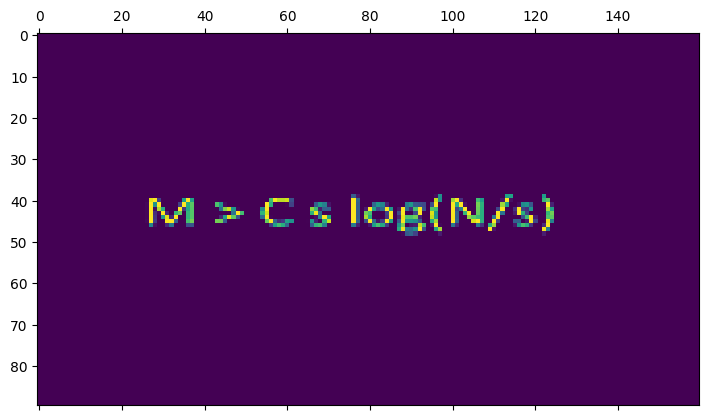

In [635]:
plt.matshow(x2.get().reshape(90, 160))

In [655]:
mat['y1'].shape

(960, 1)

In [656]:
mat['y2'].shape

(1440, 1)

In [657]:
mat['y3'].shape

(2880, 1)